In [1]:
import time
import random
import sys
from ast import literal_eval
from math import dist


from utils.gamehelper import Poe2Bot
from typing import List, Type


In [2]:
# readabilty
poe_bot:Poe2Bot
from utils.gamehelper import Entity

notebook_dev = False

In [3]:
from utils.encounters import EssenceEncounter, BreachEncounter, RitualEncounter, DeliriumEncounter
from utils.constants import ESSENCES_KEYWORD

from utils.components import PoeBotComponent 
from utils.temps import MapperCache2

# open portal and enter it
def openPortal():
  poe_bot.bot_controls.releaseAll()

  time.sleep(random.randint(40,80)/100)
  pos_x, pos_y = random.randint(709,711), random.randint(694,696)
  pos_x, pos_y = poe_bot.convertPosXY(pos_x, pos_y, safe=False)
  poe_bot.bot_controls.mouse.setPosSmooth(pos_x, pos_y)
  time.sleep(random.randint(40,80)/100)
  poe_bot.bot_controls.mouse.click()
  time.sleep(random.randint(30,60)/100)


MAPS_TO_IGNORE = [
  "MapCrypt_NoBoss", # activators
  "MapCrypt", # activators
  "MapAugury_NoBoss", # activators
  "MapAugury", # activators
  "MapFortress", #TODO class MapForptress boss activators

  "MapLostTowers", # class MapLostTowers multi layerd location
  "MapBluff", # tower
  "MapMesa", # tower
  "MapSwampTower", # multi layerd
  "MapSwampTower_NoBoss", # multi layerd
]

class MapperSettings:
  
  # 
  atlas_explorer = False # prefer to run higher tier maps over lower tier
  boss_rush = False
  alch_chisel = False # will use alch + chisel if it's possible
  alch_chisel_force = False #TODO will use alch or scour alch chisel if possible
  #TODO above will be deprecated moslikely
  
  session_duration = '24h'

  default_discovery_percent = 0.93 # % for which itll explore the area
  discovery_percent = default_discovery_percent # % for which itll explore the area
  
  prefered_tier:str = "15+"

  #TODO keep consumables same as maps.ipynb
  keep_consumables = []

  #TODO add priority to it
  low_priority_maps = []

  keep_waystones_in_inventory = 5
  waystone_upgrade_to_rare = True 
  waystone_vaal = False ##TODO if map is rare, not corrupted and identified vaal it

  max_map_run_time = 600

  force_kill_blue = False
  force_kill_rares = True

  force_deli = False
  force_breaches = False

  do_essences = True
  
  do_rituals = False
  do_rituals_buyout_function = lambda *agrs, **kwargs: True

  def __init__(self, config:dict) -> None:
    for key, value in config.items():
      setattr(self, key, value )
    print(str(self))
  def __str__(self):
    return f'[MapperSettings]: {str(vars(self))}'
class Mapper2(PoeBotComponent):
  can_pick_drop:bool = None
  def __init__(self, poe_bot:Poe2Bot, settings:MapperSettings):
    super().__init__(poe_bot)
    self.settings = settings
    self.cache = MapperCache2(unique_id=poe_bot.unique_id)
    self.current_map:MapArea
  #TODO write logic
  def doPreparations(self):
    '''
    basically just 
    - sell items if needed and
    - pick consumables if needed #call self.doStashing 
    - stash items if needed #call self.doStashing
    '''
    # pick maps from stash if dont have any
    # check if we have better maps in stash
    # sorted_maps = getMapsCanRun()
    # if len(sorted_maps) == 0:
    #   print(f'cannot find maps in stash.temp or inventory, checking stash')
    # # check if we have any better map to run in our inventory or stash
    # if sorted_maps[0].source != 'inventory':
    #   print('we have better map in stash')
    #   _maps_in_stash = list(filter(lambda i: i.source == 'stash', sorted_maps))
    #   keys_stash_tabs.extend(list(map(lambda i: i.tab_index, _maps_in_stash)))
    #   need_to_pick_something = True
    #TODO check if need to pick consumables for mapping, alch\vaal orbs
    self.cache.stage = 1
    self.cache.save()
  #TODO add some sorting for maps rather than this: map_obj = random.choice(possible_to_run_maps)
  def activateMap(self):
    '''
    open map devic
    activate map
    '''
    poe_bot:Poe2Bot = self.poe_bot
    poe_bot.ui.inventory.update()
    maps_in_inventory = list(filter(lambda i: i.map_tier, poe_bot.ui.inventory.items))
    maps_in_inventory.sort(key=lambda i: i.map_tier, reverse=prefer_high_tier)
    if len(maps_in_inventory) == 0:
      self.cache.reset()
      raise Exception("[Mapper.activateMap] len(maps_in_inventory) == 0 in activateMap")
    # open map device
    poe_bot.ui.map_device.open()
    # move to map, open dropdown
    poe_bot.ui.map_device.update()
    possible_to_run_maps = list(filter(lambda m: 
      # m.is_boss == False and # some bosses have unique logic?
      m.is_tower == False and# cant run tower maps yet
      m.is_hideout == False and# hideouts ignored
      m.is_trader == False and# manual trade
      # m.is_ritual == False and# save rituals for tests
      (m.name_raw in MAPS_TO_IGNORE) == False
    , poe_bot.ui.map_device.avaliable_maps))
    if len(possible_to_run_maps) == 0:
      poe_bot.raiseLongSleepException('dont have any maps to run visible')
    print("[Mapper.activateMap] #TODO sort maps by some criteria")
    map_obj = random.choice(possible_to_run_maps)
    print(f"[Mapper.activateMap] going to run map {map_obj.raw}")
    poe_bot.ui.map_device.moveScreenTo(map_obj)
    time.sleep(random.uniform(0.15, 0.35))
    poe_bot.ui.map_device.update()
    updated_map_obj = next( (m for m in poe_bot.ui.map_device.avaliable_maps if m.id == map_obj.id))
    updated_map_obj.click()
    time.sleep(random.uniform(0.15, 0.35))
    poe_bot.ui.map_device.update()

    if poe_bot.ui.map_device.place_map_window_opened != True:
      print(f'[Mapper.activateMap] dropdown didnt open, clicking on nearby element and clicking back again')
      #TODO filter by if its in roi
      another_map_objects = list(filter(lambda m: m.id != map_obj.id, poe_bot.ui.map_device.avaliable_maps))
      nearest_map_objects = sorted(another_map_objects, key=lambda m: dist(map_obj.screen_zone.getCenter(), m.screen_zone.getCenter()))
      nearest_map_objects[0].click()
      time.sleep(random.uniform(0.15, 0.35))
      poe_bot.ui.map_device.update()
      map_obj = next((m for m in poe_bot.ui.map_device.avaliable_maps if m.id == map_obj.id))
      map_obj.click()
      time.sleep(random.uniform(0.15, 0.35))
      poe_bot.ui.map_device.update()


      # pos_x, pos_y = poe_bot.game_window.convertPosXY(100, 100)
      # poe_bot.bot_controls.mouse.setPosSmooth(pos_x, pos_y)
      # time.sleep(random.uniform(0.15, 0.35))
      # poe_bot.ui.map_device.update()
      # updated_map_obj = next( (m for m in poe_bot.ui.map_device.avaliable_maps if m.id == map_obj.id))
      # updated_map_obj.click()
      # time.sleep(random.uniform(0.15, 0.35))
      # poe_bot.ui.map_device.update()
      if poe_bot.ui.map_device.place_map_window_opened == False:
        print(f'[Mapper.activateMap] seems like map device bug')
        raise Exception("[Mapper.activateMap] cant open dropdown for map device #TODO click on other map element in roi and try again?")
        poe_bot.raiseLongSleepException("[Mapper.activateMap] cant open dropdown for map device #?")
    poe_bot.ui.map_device.update()
    
    
    
    
    print("[Mapper.activateMap] dropdown opened")
    if len(poe_bot.ui.map_device.place_map_window_items) != 0:
      poe_bot.raiseLongSleepException('[Mapper.activateMap] len(poe_bot.ui.map_device.place_map_window_items) != 0 #TODO remove all, test below')
      poe_bot.ui.clickMultipleItems(poe_bot.ui.map_device.place_map_window_items)
    poe_bot.ui.inventory.update()
    maps_in_inventory = list(filter(lambda i: i.map_tier, poe_bot.ui.inventory.items))
    maps_in_inventory.sort(key=lambda i: i.map_tier, reverse=prefer_high_tier)
    map_to_run = maps_in_inventory[0]
    print(f'[Mapper.activateMap] going to run map: {map_to_run.raw}')
    if self.settings.waystone_upgrade_to_rare == True:
      while True:
        if map_to_run.rarity != "Normal":
        #TODO identified poe2 broken from hud?
        # if map_to_run.rarity != "Normal" or map_to_run.identified == False:
          print(f'[Mapper.activateMap] cant modify {map_to_run.raw}')
          break
        alchemy_orbs = list(filter(lambda i: i.name == "Orb of Alchemy", poe_bot.ui.inventory.items))
        if len(alchemy_orbs) == 0:
          break
        print(f'')
        alchemy_orb = alchemy_orbs[0]
        alchemy_orb.click(button="right")
        time.sleep(random.uniform(0.4, 1.2))
        map_to_run.click()
        time.sleep(random.uniform(0.8, 1.2))
        break
    while True:
      print(f'[Mapper.activateMap] #TODO self.settings.waystone_vaal, vaal map if possible')
      break
    print(f'[Mapper.activateMap] placing map {map_to_run.raw} #TODO update map item after modifications')
    map_to_run.click(hold_ctrl=True)
    time.sleep(random.uniform(0.4, 1.2))

    poe_bot.ui.map_device.update()
    poe_bot.ui.map_device.checkIfActivateButtonIsActive()
    poe_bot.ui.map_device.activate()
    poe_bot.helper_functions.waitForNewPortals()

    self.cache.stage = 2
    self.cache.save()
  def doStashing(self):
    poe_bot = self.poe_bot
    # free inventory if needed
    poe_bot.ui.inventory.update()
    empty_slots = poe_bot.ui.inventory.getEmptySlots()
    if len(empty_slots) < 40:
      poe_bot.ui.stash.open()
      items_to_keep = []
      poe_bot.ui.inventory.update()
      waystones_to_keep = list(filter(lambda i: i.map_tier, poe_bot.ui.inventory.items))
      waystones_to_keep.sort(key=lambda i: i.map_tier, reverse=prefer_high_tier)
      items_to_keep.extend(waystones_to_keep[:self.settings.keep_waystones_in_inventory-1])
      alchemy_orbs = list(filter(lambda i: i.name == "Orb of Alchemy", poe_bot.ui.inventory.items))
      items_to_keep.extend(alchemy_orbs[:1])
      items_can_stash = list(filter(lambda i: i not in items_to_keep, poe_bot.ui.inventory.items))
      poe_bot.ui.clickMultipleItems(items_can_stash)
      poe_bot.ui.closeAll()
      time.sleep(random.uniform(0.3, 1.4))
  def isMapCompleted(self):
    poe_bot = self.poe_bot
    poe_bot.game_data.map_info.update()
    if poe_bot.game_data.map_info.map_completed != True:
      print(f'[Mapper.isMapCompleted] poe_bot.game_data.map_info.map_completed {poe_bot.game_data.map_info.map_completed}')
      return False
    if self.settings.do_rituals == True:
      poe_bot.ui.ritual_ui.update()
      if poe_bot.ui.ritual_ui.ritual_button != None:
        rituals_left = poe_bot.ui.ritual_ui.progress_total - poe_bot.ui.ritual_ui.progress_current
        if rituals_left != 0:
          print(f'[Mapper.isMapCompleted] ritual progress {poe_bot.ui.ritual_ui.progress_total}/{poe_bot.ui.ritual_ui.progress_current} rituals left {rituals_left}')
          return False 
    return True
  def run(self, nested=False):
    poe_bot = self.poe_bot
    in_instance = not 'Hideout' in poe_bot.game_data.area_raw_name# and not "_town_" in poe_bot.game_data.area_raw_name
    print(f'[Mapper2.run] current instance: {poe_bot.game_data.area_raw_name} in_instance {in_instance}')
    if self.cache.stage == 0:
      # self.checkIfSessionEnded()
      self.doPreparations()
    if self.cache.stage == 1:
      self.activateMap()
    if self.cache.stage == 2:

      # #TODO part below is somewhere here
      # time.sleep(random.uniform(0.8, 1.6))
      # poe_bot.helper_functions.waitForNewPortals()
      # poe_bot.refreshInstanceData()
      # original_area_raw_name = poe_bot.game_data.area_raw_name
      # poe_bot.helper_functions.getToPortal(check_for_map_device=False, refresh_area=True)
      # area_changed = False
      # while area_changed != True:
      #   poe_bot.refreshAll()
      #   area_changed = poe_bot.game_data.area_raw_name != original_area_raw_name


      # self.poe_bot.combat_module.build.doPreparations()
      if in_instance is False:
        if self.cache.map_completed is True:
          self.cache.reset()
          poe_bot.logger.writeLine('map completed')
          if nested == False:
            self.run(True);return
          else:
            raise Exception('[Mapper2.run] map is completed and in hideout, restart')
        self.doStashing()
        
        original_area_raw_name = poe_bot.game_data.area_raw_name
        portals = poe_bot.game_data.entities.town_portals
        if len(portals) == 0:
          self.cache.reset()
          raise Exception('[Mapper2.run] no portals left to enter')
        poe_bot.mover.goToEntitysPoint(portals[0], min_distance=30, release_mouse_on_end=True)
        while poe_bot.game_data.invites_panel_visible == False:
          portals[0].click(update_screen_pos=True)
          time.sleep(random.uniform(0.3,0.7))
          try:
            poe_bot.refreshInstanceData()
          except Exception as e:
            if e.__str__() in ["area is loading on partial request", "Area changed but refreshInstanceData was called before refreshAll"]:
              break
        area_changed = False
        while area_changed != True:
          poe_bot.refreshAll()
          area_changed = poe_bot.game_data.area_raw_name != original_area_raw_name
    
    #TODO move to if self.cache.stage == 2
    self.current_map = getMapArea(poe_bot.game_data.area_raw_name)(poe_bot=poe_bot, mapper=self)
    self.current_map.complete()
    self.onMapFinishedFunction()
  def exploreRoutine(self, *args, **kwargs):
    poe_bot = self.poe_bot
    mapper = self
    settings = mapper.settings
    current_area = self.current_map

    # if it runs map for more than 
    if current_area.started_running_map_at + settings.max_map_run_time < time.time():
      poe_bot.logger.writeLine(f'[MapArea.exploreRoutine] started at {current_area.started_running_map_at}, limit {settings.max_map_run_time}, time now {time.time()}, stuck')
      poe_bot.on_stuck_function() 
    # activate mirror if find it
    if settings.force_deli != False and mapper.cache.delirium_mirror_activated is False:
      delirium_mirror = next((e for e in poe_bot.game_data.entities.all_entities if e.path == "Metadata/Terrain/Gallows/Leagues/Delirium/Objects/DeliriumInitiator" and e.is_opened != True and e.isOnPassableZone()), None)
      if delirium_mirror:
        DeliriumEncounter(delirium_mirror).doEncounter()
        mapper.cache.delirium_mirror_activated = True
        mapper.cache.save()
        return True
    
    #TODO, supposed to step on those shard packs to open them
    # Metadata/Monsters/LeagueDelirium/DoodadDaemons/DoodadDaemonShardPack<smth> or 1 only is metadata key for those things
    if settings.force_deli:
      pass
    
    # TODO custom break function to check if there are any other activators which are closer on our way
    if current_area.activators_on_map:
      activators_on_map = list(filter(lambda e: e.is_targetable != False and e.path in current_area.activators_on_map, poe_bot.game_data.entities.all_entities))
      if len(activators_on_map) != 0:
        activator_on_map = activators_on_map[0]
        poe_bot.mover.goToEntitysPoint(activator_on_map)
        activator_on_map.clickTillNotTargetable()
        return True
    if settings.force_kill_rares != False:
      mob_to_kill = next( (e for e in poe_bot.game_data.entities.attackable_entities_rares if e.isOnPassableZone()), None)
      if mob_to_kill:
        poe_bot.combat_module.killUsualEntity(mob_to_kill)
        return True
    if settings.force_kill_blue != False:
      mob_to_kill = next( (e for e in poe_bot.game_data.entities.attackable_entities_blue if e.isOnPassableZone()), None)
      if mob_to_kill:
        poe_bot.combat_module.killUsualEntity(mob_to_kill)
        return True
    if settings.do_essences != False:
      if len(poe_bot.game_data.entities.essence_monsters) != 0:
        print(f'got essenced mobs, killing them')
        for entity in poe_bot.game_data.entities.essence_monsters:
          poe_bot.combat_module.killUsualEntity(entity=entity)
        return True
      essence = next((e for e in poe_bot.game_data.entities.all_entities if e.is_targetable is True and ESSENCES_KEYWORD in e.path and e.isOnPassableZone()), None)
      if essence:
        essence_encounter = EssenceEncounter(poe_bot, essence)
        essence_encounter.doEncounter()
        poe_bot.loot_picker.collectLoot()
        return True
    if settings.force_breaches != False:
      breach_entity = next( (e for e in poe_bot.game_data.entities.all_entities if e.path == "Metadata/MiscellaneousObjects/Breach/BreachObject"), None)
      if breach_entity:
        BreachEncounter(poe_bot, breach_entity).doEncounter()
        return True
    if settings.do_rituals != False:
      ritual_entity = next( (e for e in poe_bot.game_data.entities.all_entities if e.path == "Metadata/Terrain/Leagues/Ritual/RitualRuneInteractable" and not e.id in mapper.cache.ritual_ignore_ids), None)
      if ritual_entity:
        poe_bot.mover.goToEntitysPoint(ritual_entity, min_distance=100)
        poe_bot.game_data.minimap_icons.update()
        corresponding_icon = next( (i for i in poe_bot.game_data.minimap_icons.icons if i.id == ritual_entity.id), None)
        if not corresponding_icon:
          poe_bot.mover.goToEntitysPoint(ritual_entity, min_distance=50)
        poe_bot.game_data.minimap_icons.update()
        corresponding_icon = next( (i for i in poe_bot.game_data.minimap_icons.icons if i.id == ritual_entity.id), None)
        if not corresponding_icon:
          print('ritual minimap icon is not in hud, ignoring')
          mapper.cache.ritual_ignore_ids.append(ritual_entity.id)
          mapper.cache.save()
          return True
        if corresponding_icon.name == "RitualRuneFinished":
          print('according to minimap icon data, ritual is finished')
          mapper.cache.ritual_ignore_ids.append(ritual_entity.id)
          mapper.cache.save()
          return True
        RitualEncounter(poe_bot, ritual_entity).doEncounter()
        mapper.cache.ritual_ignore_ids.append(ritual_entity.id)
        mapper.cache.save()
        return True
    #TODO map bossrooms
    # kill map bosses if theyre presented on maps
    # if self.ignore_bossroom is None:
    #   self.setIgnoreBossroom()
    # if self.ignore_bossroom is False and self.current_map.ignore_bossroom is False:
    #   if self.current_map.bossroom_activator:
    #     bossroom_activator = next( (e for e in poe_bot.game_data.entities.all_entities if e.is_targetable is True and e.path == self.current_map.bossroom_activator), None)
    #     if bossroom_activator:
    #       bossroom_activator.clickTillNotTargetable()
    #       return True
    #   bossrooms = self.seekForBossrooms()
    #   if len(bossrooms) != 0:
    #     bossroom = bossrooms[0]
    #     self.clearBossroom(bossroom=bossrooms[0])
    #     self.temp.cleared_bossrooms.append(bossroom.id)
    #     self.temp.save()
    #     return True
    
    #TODO sometimes boss spawn can be outside of passable area, or activators for boss
    map_boss = next( (e for e in self.poe_bot.game_data.entities.unique_entities if e.life.health.current != 0 and e.is_hostile != False and e.isOnPassableZone()), None)
    # if current_area.boss_render_names:
    #   map_boss = next( (e for e in self.poe_bot.game_data.entities.unique_entities if e.life.health.current != 0 and e.render_name in current_area.boss_render_names and e.isOnPassableZone()), None)
    if map_boss:
      current_area.killMapBoss(map_boss)
      mapper.cache.map_boss_killed = True
      mapper.cache.save()
      #TODO is it used?
      mapper.cache.map_boss_killed = True
      mapper.cache.killed_map_bosses_render_names.append(map_boss.render_name)
      return True
    if mapper.can_pick_drop == None:
      if len(poe_bot.ui.inventory.getFilledSlots()) > 51:
        mapper.can_pick_drop = False
      else:
        mapper.can_pick_drop = True
    if mapper.can_pick_drop != False:
      loot_collected = poe_bot.loot_picker.collectLoot()
      if loot_collected is True:
        if len(poe_bot.ui.inventory.getFilledSlots()) > 51:
          mapper.can_pick_drop = False
        else:
          mapper.can_pick_drop = True
        return True
    
    # TODO passable transitions
    # TODO check if area is on a currently passable area or somewhere around
    # area_transitions = list(filter(lambda e: e.rarity == 'White' and e.render_name != 'Arena' and e.id not in mapper.temp.visited_transitions_ids and e.id not in unvisited_transitions_ids, poe_bot.game_data.entities.area_transitions))
    # unvisited_transitions_ids = list(map(lambda e: e['i'], mapper.cache.unvisited_transitions))
    # area_transitions = list(filter(lambda e: 
    #   e.rarity == 'White' 
    #   and e.is_targetable == True 
    #   and e.render_name != '' 
    #   and e.render_name != "Twisted Burrow" # affliction enterance
    #   and e.path != "Metadata/Terrain/Leagues/Azmeri/WoodsEntranceTransition" # affliction enterance
    #   and e.path != "Metadata/MiscellaneousObjects/PortalToggleableNew" # affliction enterance
    #   and e.path != "Metadata/MiscellaneousObjects/PortalToggleable" # affliction enterance
    #   and e.render_name != self.arena_render_name 
    #   and e.render_name not in self.transitions_to_ignore_render_names
    #   # and (len(self.current_map.transitions_to_ignore_render_names) != 0 and e.render_name not in self.current_map.transitions_to_ignore_render_names)
    #   and e.render_name != 'Syndicate Laboratory' # betrayal Laboratory 
    #   and "Metadata/Terrain/Leagues/Incursion/Objects/IncursionPortal" not in e.path # alva
    #   and 'Metadata/QuestObjects/Labyrinth/LabyrinthTrialPortal' not in e.path # lab trial
    #   and e.id not in mapper.cache.visited_transitions_ids 
    #   and e.id not in unvisited_transitions_ids 
    #   and e.id not in mapper.cache.currently_ignore_transitions_id
    #   and e.render_name != "Starfall Crater",
    # poe_bot.game_data.entities.area_transitions))
    # if len(area_transitions) != 0:
    #   new_transition_found = False
    #   for area_transition in area_transitions:
    #     object_reachable = poe_bot.game_data.terrain.checkIfPointPassable(area_transition.grid_position.x, area_transition.grid_position.y)
    #     if object_reachable is False:
    #       mapper.cache.currently_ignore_transitions_id.append(area_transition.id)
    #     else:
    #       print(f'found new transition {str(area_transition)}')
    #       mapper.cache.unvisited_transitions.append(area_transition.raw)
    #       new_transition_found = True
    #   if new_transition_found is True:
    #     return True  
    #   return True
    return False
 # TODO open portal with first attempt?
  def onMapFinishedFunction(self):
    poe_bot = self.poe_bot
    if hasattr(poe_bot.game_data.terrain, "currently_passable_area") == False:
      poe_bot.game_data.terrain.getCurrentlyPassableArea()
    self.cache.map_streak += 1
    self.cache.map_completed = True
    self.cache.save()
    print(f'[Mapper] onMapFinishedFunction call at {time.time()}')
    print('#TODO self.deactivateDeliriumMirror()')
    '''
    poe_bot.ui.delirium_ui.update()
    if poe_bot.ui.delirium_ui.disable_button != None:
      poe_bot.ui.delirium_ui.disable_button.click()
    '''
    map_finish_time = time.time() 
    time_now = time.time()
    rev = bool(random.randint(0,1))
    while time_now < map_finish_time + 1 :
      poe_bot.refreshInstanceData()
      killed_someone = poe_bot.combat_module.clearLocationAroundPoint({"X":self.poe_bot.game_data.player.grid_pos.x, "Y":self.poe_bot.game_data.player.grid_pos.y},detection_radius=50)
      res = self.exploreRoutine()
      if killed_someone is False and res is False:
        point = poe_bot.game_data.terrain.pointToRunAround(
          point_to_run_around_x=self.poe_bot.game_data.player.grid_pos.x,
          point_to_run_around_y=self.poe_bot.game_data.player.grid_pos.y,
          distance_to_point=15,
          reversed=rev
        )
        poe_bot.mover.move(grid_pos_x = point[0], grid_pos_y = point[1])
        poe_bot.refreshInstanceData()
      time_now = time.time()

    # check if we did 3 of 3 or 4of4 rituals, if true, defer\whatever items
    self.settings.do_rituals_buyout_function()

    poe_bot.refreshInstanceData()
    #TODO poe1
    # print(f'[Mapper.onMapFinishedFunction] leveling gems at {time.time()}')
    # for i in range(random.randint(3,5)):
    #   res = poe_bot.helper_functions.lvlUpGem()
    #   if res != 1:
    #     break
    i = 0
    random_click_iter = 0
    can_click_portal_after = time.time()
    while True:
      while True:
        poe_bot.refreshInstanceData()
        res = poe_bot.loot_picker.collectLoot()
        if res is False:
          break
      if poe_bot.game_data.invites_panel_visible != False:
        print(f'[Mapper.onMapFinishedFunction] already loading')
      else:
        i+= 1
        random_click_iter += 1
        if random_click_iter > 15:
          print('[Mapper] cannot get to portal, clicking random point around the player')
          poe_bot.ui.closeAll()
          # points = getFourPoints(x = poe_bot.game_data.player.grid_pos.x, y = poe_bot.game_data.player.grid_pos.y, radius = random.randint(7,13))
          # point = random.choice(points)
          point = poe_bot.game_data.terrain.pointToRunAround(poe_bot.game_data.player.grid_pos.x, poe_bot.game_data.player.grid_pos.y, distance_to_point=random.randint(15,25), check_if_passable=True)
          pos_x, pos_y = poe_bot.getPositionOfThePointOnTheScreen(y=point[1], x=point[0])
          pos_x, pos_y = poe_bot.convertPosXY(x=pos_x, y=pos_y)
          poe_bot.bot_controls.mouse.setPosSmooth(pos_x, pos_y)
          poe_bot.bot_controls.mouse.click()
          random_click_iter = random.randint(0,3)
        if i > 200:
          poe_bot.raiseLongSleepException('portal bug')
        nearby_portals = list(filter(lambda e: e.distance_to_player < 50, poe_bot.game_data.entities.town_portals))
        if len(nearby_portals) == 0:
          #TODO poe_bot.helper_functions.openPortal()
          openPortal()
          nearby_portals = list(filter(lambda e: e.distance_to_player < 50, poe_bot.game_data.entities.town_portals))

        if len(nearby_portals) != 0 and time.time() > can_click_portal_after:
          print(f'[Mapper.onMapFinishedFunction] clicking on portal')
          poe_bot.refreshInstanceData()
          nearby_portals = list(filter(lambda e: e.distance_to_player < 50, poe_bot.game_data.entities.town_portals))
          nearby_portals.sort(key=lambda e: e.distance_to_player)
          nearest_portal = nearby_portals[0]
          nearest_portal.click()
          can_click_portal_after = time.time() + random.randint(5,15)/10
          print(f'[Mapper.onMapFinishedFunction] can_click_portal_after {can_click_portal_after}')
      poe_bot.combat_module.clearLocationAroundPoint({"X": self.poe_bot.game_data.player.grid_pos.x, "Y": self.poe_bot.game_data.player.grid_pos.y},detection_radius=50)
      self.exploreRoutine()
class MapArea(PoeBotComponent):
  boss_render_names:List[str] = []
  activators_on_map:List[str] = []
  entities_to_ignore_in_bossroom_path_keys:List[str] = []
  boss_clear_around_radius:int = 50
  def __init__(self, poe_bot, mapper:Mapper2):
    super().__init__(poe_bot)
    self.mapper = mapper
  #TODO rewrite some breaks to return, merge %of discovery with mapper.isMapCompleted 
  def complete(self):
    mapper = self.mapper
    poe_bot = self.poe_bot
    

    self.started_running_map_at = time.time()

    can_go_to_another_transition = False
    tsp = poe_bot.pather.tsp

    poe_bot.refreshInstanceData()
    while mapper.cache.map_completed is False:
      print(f'generating pathing points')
      tsp.generatePointsForDiscovery()
      # if mapper.settings.boss_rush is True:
      #   discovery_points = tsp.sortedPointsForDiscovery(poe_bot.pather.utils.getFurthestPoint(poe_bot.game_data.player.grid_pos.toList()))
      # else:
      discovery_points = tsp.sortedPointsForDiscovery()
      print(f'len(discovery_points) {len(discovery_points)}')
      discovery_points = list(filter(lambda p: poe_bot.game_data.terrain.checkIfPointPassable(p[0], p[1]), discovery_points))
      print(f'len(discovery_points) {len(discovery_points)} after sorting')
      if len(discovery_points) == 0:
        print(f'len(discovery_points) == 0 after points generation')
        mapper.cache.map_completed = True
        break
      point_to_go = discovery_points.pop(0)
      while point_to_go is not None and mapper.cache.map_completed is False:
        # check if point needs to be explored
        need_to_explore = poe_bot.game_data.terrain.isPointVisited(point_to_go[0], point_to_go[1])
        #TODO rewrite block below
        if need_to_explore is True:
          print(f'exploring point {point_to_go}')
        else:
          print(f'surrounding around {point_to_go} discovered, skipping')
          try:
            point_to_go = discovery_points.pop(0)
          except:
            point_to_go = None
          continue
        print(f'point_to_go {point_to_go}')
        # endblock

        # go to point to make it explored
        result = poe_bot.mover.goToPoint(
          point=point_to_go,
          min_distance=50,
          release_mouse_on_end=False,
          custom_break_function=self.mapper.exploreRoutine,
          step_size=random.randint(30,35)
        )
        # then, it result is True, False or None
        print(f"[MapArea.complete] mover.goToPoint result {result}")

        if self.mapper.isMapCompleted() == True:
          mapper.cache.map_completed = True
          break

        # if mapper.settings.boss_rush is True and mapper.cache.map_boss_killed is True:
        #   print(f'[MapArea.complete] killed map boss on boss rush')
        #   mapper.cache.map_completed = True
        #   break

        #TODO below is block for multi layerd maps
        # check if we have transitions (excluding bossrooms, vaal, #TODO hideout, betrayal,)
        # if len(mapper.temp.unvisited_transitions):
        #   need_to_go_to_next_transition = can_go_to_another_transition
        #   if mapper.boss_rush is True:
        #     need_to_go_to_next_transition = True
        #   else:
        #     print(f'mapper.temp.unvisited_transitions {mapper.temp.unvisited_transitions}')
        #     passable_area_discovered_percent = poe_bot.game_data.terrain.getPassableAreaDiscoveredForPercent(total=False)
        #     print(f'passable_area_discovered_percent {passable_area_discovered_percent}')
        #     # check if current area visited percent > 75%:
        #     if passable_area_discovered_percent > 0.75:
        #       need_to_go_to_next_transition = True

        #   if need_to_go_to_next_transition is True:
        #     # check if unvisited transitions == 1: otherwise raise error
        #     raw_transition_entity = mapper.temp.unvisited_transitions.pop(0)
        #     # mapper.temp.save()
        #     transition_entity = Entity(poe_bot, raw_transition_entity)
        #     while True:
        #       res = mover.goToPoint(
        #         point=[transition_entity.grid_position.x, transition_entity.grid_position.y],
        #         min_distance=30,
        #         release_mouse_on_end=False,
        #         custom_continue_function=build.usualRoutine,
        #         custom_break_function=poe_bot.loot_picker.collectLoot,
        #         step_size=random.randint(25,33)
        #       )
        #       if res is None:
        #         break
        #     mover.enterTransition(transition_entity)
        #     poe_bot.refreshInstanceData()
        #     exit_transitions = []
        #     look_for_exit_transition = 0
        #     while len(exit_transitions) == 0:
        #       look_for_exit_transition += 1
        #       if look_for_exit_transition == 20 or look_for_exit_transition == 40:
        #         poe_bot.backend.forceRefreshArea()
        #       if look_for_exit_transition > 100:
        #         poe_bot.on_stuck_function()
        #         raise Exception('look_for_exit_transition > 100:')
        #         # poe_bot.raiseLongSleepException('look_for_exit_transition > 100:')
        #         # break
        #       poe_bot.refreshInstanceData(reset_timer=True)
        #       exit_transitions = list(filter(lambda e: e.rarity == 'White' and e.id != transition_entity.id, poe_bot.game_data.entities.area_transitions))

              
        #     exit_transition = exit_transitions[0]
        #     mapper.temp.visited_transitions_ids.append(exit_transition.id)
        #     mapper.temp.visited_transitions_ids.append(transition_entity.id)
        #     mapper.temp.transition_chain.append(transition_entity.raw)
        #     mapper.temp.save()
        #     can_go_to_another_transition = False
        #     break
        #ENDBLOCK

        #TODO useful?
        # if map was discovered
        if mapper.settings.boss_rush is False and (mapper.settings.atlas_explorer is False or mapper.cache.map_boss_killed is True) and poe_bot.game_data.terrain.getPassableAreaDiscoveredForPercent(total=True) >= mapper.settings.discovery_percent:
          if mapper.cache.unvisited_transitions != []:
            print(f'willing to finish the map, but got another transition to visit')
            can_go_to_another_transition = True
            continue
          print(f'discovered for more than {int(mapper.settings.discovery_percent*100)} percents, breaking')
          mapper.cache.map_completed = True
          break


        # if we arrived to discovery point and nothing happened
        if result is None:
          while True:
            if len(discovery_points) == 0:
              if mapper.settings.boss_rush is True or mapper.settings.discovery_percent > mapper.settings.default_discovery_percent:
                print(f'mapper.boss_rush is True or custom_discovery_percent and len(discovery_points) == 0')
                print(f'generating new points')
                point_to_go = None
                break
              else:
                point_to_go = None
                mapper.cache.map_completed = True
                print(f'len(discovery_points) == 0, breaking')
                break

            point_to_go = discovery_points.pop(0)
            print(f'willing to explore next point {point_to_go}')
            need_to_explore = poe_bot.game_data.terrain.isPointVisited(point_to_go[0], point_to_go[1])

            if need_to_explore is True:
              print(f'exploring point {point_to_go}')
              break
            else:
              print(f'surrounding around {point_to_go} discovered, skipping')
              continue 
        
        poe_bot.refreshInstanceData()
        poe_bot.last_action_time = 0


    # main loop from quest.py and maps.py 
  #TODO check for quest.py for better samples
  def killMapBoss(self, entity:Entity):
    start_time = time.time()
    print(f'[MapArea.killmapboss] {start_time} {entity.raw}')
    boss_entity = entity
    boss_entity_id = boss_entity.id
    if boss_entity.is_targetable is False or boss_entity.is_attackable is False:
      print(f'boss is not attackable or not targetable, going to it and activating it')
      while True:
        # if self.activator_inside_bossroom is not None and self.activated_activator_in_bossroom is False:
        #   activator:Entity = next((e for e in poe_bot.game_data.entities.all_entities if e.path == self.current_map.activator_inside_bossroom), None)
        #   if activator:
        #     if activator.is_targetable is True:
        #       self.activate(activator)
        #     self.activated_activator_in_bossroom = True
        res = poe_bot.mover.goToEntitysPoint(
          boss_entity,
          min_distance=15,
          # custom_break_function=poe_bot.loot_picker.collectLoot,
          release_mouse_on_end=False,
          step_size=random.randint(25,33),
          #TODO poe1
          # possible_transition = self.current_map.possible_transition_on_a_way_to_boss
        )
        if res is None:
          break
      last_boss_pos_x, last_boss_pos_y = boss_entity.grid_position.x, boss_entity.grid_position.y
      
      while True:
        if start_time + 120 < time.time():
          print(f'killing boss for more than 120 seconds')
          poe_bot.on_stuck_function() 
        boss_entity = list(filter(lambda e: e.id == boss_entity_id, poe_bot.game_data.entities.all_entities))
        if len(boss_entity) == 0:
          print(f'len(boss_entity) == 0 corpse disappeared:')
          return True
        
        boss_entity = boss_entity[0]
        if boss_entity.life.health.current == 0:
          print(f'boss is dead')
          return True
        if boss_entity.is_targetable is False or boss_entity.is_attackable is False:
          print(f'boss is not attackable or not targetable, going to it clearing around it {boss_entity.raw}')
          killed_someone = poe_bot.combat_module.clearLocationAroundPoint(
            {"X":boss_entity.grid_position.x, "Y":boss_entity.grid_position.y}, 
            detection_radius=self.boss_clear_around_radius, 
            ignore_keys=self.entities_to_ignore_in_bossroom_path_keys
          )
          if killed_someone is False:
            point = poe_bot.game_data.terrain.pointToRunAround(
              point_to_run_around_x=last_boss_pos_x,
              point_to_run_around_y=last_boss_pos_y,
              distance_to_point=15,
            )
            poe_bot.mover.move(grid_pos_x = point[0], grid_pos_y = point[1])
          poe_bot.refreshInstanceData(reset_timer=killed_someone)
        else:
          print(f'boss is attackable and targetable, going to kill it')
          poe_bot.combat_module.killUsualEntity(boss_entity, max_kill_time_sec=30)
          last_boss_pos_x, last_boss_pos_y = boss_entity.grid_position.x, boss_entity.grid_position.y
    else:
      print(f'boss is attackable and targetable, going to kill it')
      poe_bot.combat_module.killUsualEntity(boss_entity)

# add custom logic or whatever thing
class MapBackwash(MapArea):
  boss_render_names = ["Yaota, the Loathsome"]
class MapDecay(MapArea):
  boss_render_names = ["The Fungus Behemoth"]
class MapBloomingField(MapArea):
  boss_render_names = ["The Black Crow"]
class MapFortress(MapArea):
  boss_render_names = ["Pirasha, the Forgotten Prisoner"]
  # "Metadata/Terrain/Gallows/Act2/2_2/Objects/BossChainAnchor_1"
  # "Metadata/Terrain/Gallows/Act2/2_2/Objects/BossChainAnchor_2"
  # "Metadata/Terrain/Gallows/Act2/2_2/Objects/BossChainAnchor_3"
  boss_activators_paths = ["Metadata/Terrain/Gallows/Act2/2_2/Objects/BossChainAnchor"] 
  # or list(map(lambda i: f"Metadata/Terrain/Gallows/Act2/2_2/Objects/BossChainAnchor_{i}"), [1,2,3])
class MapLostTowers(MapArea):
  # init, change strategy to boss rush
  pass
MAP_AREAS_BY_KEYS_DICT = {
  "MapLostTowers": MapLostTowers, 
  "MapDecay": MapDecay,
  "MapBloomingField": MapBloomingField,
}
def getMapArea(current_area_string:str) -> Type[MapArea]:
  return MAP_AREAS_BY_KEYS_DICT.get(current_area_string, MapArea)

# settings
prefer_high_tier = True
alch_map_if_possible = True




In [ ]:
default_config = {
  "REMOTE_IP": '172.30.96.254', # z2
  "unique_id": "poe_2_test",
  "build": "EaBallistasEle",
  "password": None,
  "max_lvl": 101,
  "chromatics_recipe": True,
  "force_reset_temp": False,
}



try:
  i = sys.argv[1]
  print(i)
  parsed_config = literal_eval(i)
  print(f'successfully parsed cli config')
  print(f'parsed_config: {parsed_config}')
except:
  print(f'cannot parse config from cli, using default\dev one')
  notebook_dev = True
  parsed_config = default_config
  parsed_config['unique_id'] = Poe2Bot.getDevKey()

config = {

}

for key in default_config.keys():
  config[key] = parsed_config.get(key, default_config[key])

print(f'config to run {config}')

REMOTE_IP = config['REMOTE_IP'] # REMOTE_IP
UNIQUE_ID = config['unique_id'] # unique id
MAX_LVL = config.get('max_lvl')
CHROMATICS_RECIPE = config['chromatics_recipe']
BUILD_NAME = config['build'] # build_name
password = config['password']
force_reset_temp = config['force_reset_temp']
print(f'running aqueduct using: REMOTE_IP: {REMOTE_IP} unique_id: {UNIQUE_ID} max_lvl: {MAX_LVL} chromatics_recipe: {CHROMATICS_RECIPE} force_reset_temp: {force_reset_temp}')

In [ ]:
poe_bot = Poe2Bot(unique_id = UNIQUE_ID, remote_ip = REMOTE_IP, password=password)
poe_bot.refreshAll()
# poe_bot.game_data.terrain.getCurrentlyPassableArea()
# TODO move it to poe_bot.refreshAll() refreshed_data["c_t"] ## "c_t":0 - mouse || "c_t":1 - wasd
poe_bot.mover.setMoveType('wasd')


In [6]:
# set up build

# from utils.combat import InfernalistZoomancer
# poe_bot.combat_module.build = InfernalistZoomancer(poe_bot=poe_bot)

# from utils.combat import GenericBuild2
# poe_bot.combat_module.build = GenericBuild2(poe_bot=poe_bot)

# from utils.combat import GenericBuild2Cautious
# poe_bot.combat_module.build = GenericBuild2Cautious(poe_bot=poe_bot)

# from utils.combat import PathfinderPoisonConc2
# poe_bot.combat_module.build = PathfinderPoisonConc2(poe_bot=poe_bot)
# poe_bot.combat_module.build.auto_flasks.life_flask_recovers_es = True
# poe_bot.combat_module.build.auto_flasks.hp_thresh = 0.70



In [ ]:
from utils.combat import Build, SkillWithDelay, DodgeRoll
from utils.mover import Mover
from utils.utils import createLineIteratorWithValues
from utils.utils import extendLine
from utils.constants import CONSTANTS

import numpy as np

import _thread

class ButtonHolder:
  def __init__(self, poe_bot:Poe2Bot, button:str, max_hold_duration = 10., custom_break_function=lambda: False):
    self.poe_bot = poe_bot
    self.thread_finished = [False]
    self.can_hold_till = [0]
    self.custom_break_function = custom_break_function

    self.button = button
    self.press_func = poe_bot.bot_controls.keyboard_pressKey
    self.release_func = poe_bot.bot_controls.keyboard_releaseKey

    self.max_hold_duration = max_hold_duration

    self.keep_thread_till = 0.
    self.terminate_thread_after_inactivity_secs = 2.

    self.running = False
  def start(self):
    self.running = True
    print(f'[ButtonHolder.start] started at {time.time()}')
    while self.thread_finished[0] != True:
      if time.time() < self.can_hold_till[0]:
        if (self.button in poe_bot.bot_controls.keyboard.pressed) == False:
          print(f'pressing button {self.button}')
          self.press_func(self.button, False)
      else:
        if (self.button in poe_bot.bot_controls.keyboard.pressed):
          print(f'releasing button {self.button}')
          self.release_func(self.button, False)

      if time.time() > self.keep_thread_till:
        print('terminating thread due to inactivity')
        break
      
      if self.custom_break_function() == True:
        print('breaking because of condition')
        break
      time.sleep(0.02)
    if (self.button in poe_bot.bot_controls.keyboard.pressed):
      print(f'releasing button {self.button}')
      self.release_func(self.button, False)
    print(f'[ButtonHolder.start] finished at {time.time()}')
    self.running = False
  
  def keepAlive(self):
    self.keep_thread_till = time.time() + self.terminate_thread_after_inactivity_secs

  def forceStopPress(self):
    self.keepAlive()
    self.can_hold_till[0] = 0
    print(f'releasing')
  def holdFor(self, t:float):
    self.keepAlive()
    self.can_hold_till[0] = time.time() + t
    print(f"will hold till {self.can_hold_till[0]}")
    if self.running != True:
      _thread.start_new_thread(self.start, ())
class BarrierInvocationInfernalist(Build):
  def __init__(self, poe_bot):
    super().__init__(poe_bot)
    self.auto_flasks.life_flask_recovers_es = True
    self.auto_flasks.hp_thresh = 0.75
    self.can_use_flask_after = 0.
    self.barrier_charged_at = 0.
    self.es_thresh_for_loop = 0.66
    self.stop_spamming_condition_func = lambda: poe_bot.game_data.player.life.energy_shield.getPercentage() < self.es_thresh_for_loop

    self.barrier_invocation:SkillWithDelay
    self.curse:SkillWithDelay
    self.demon_form:SkillWithDelay

    demon_form = next((s for s in poe_bot.game_data.skills.internal_names if s == "demon_transformation"), None)
    if demon_form:
      print('found demon form')
      skill_index = poe_bot.game_data.skills.internal_names.index("demon_transformation")
      self.demon_form = SkillWithDelay(poe_bot, skill_index)
    else:
      raise Exception("demon form not found")
    curse = next((s for s in poe_bot.game_data.skills.internal_names if s == "cold_weakness"), None)
    if curse:
      print('found curse')
      skill_index = poe_bot.game_data.skills.internal_names.index("cold_weakness")
      self.curse = SkillWithDelay(poe_bot, skill_index, min_delay=0.1)
    else:
      raise Exception("cwdt activator not found")
    
    barrier = next((s for s in poe_bot.game_data.skills.internal_names if s == "barrier_invocation"), None)
    if barrier:
      print('found barrier_invocation')
      skill_index = poe_bot.game_data.skills.internal_names.index("barrier_invocation")
      self.barrier_invocation = SkillWithDelay(poe_bot, skill_index, min_delay=0.1)
      self.barrier_invocation_key_holder = ButtonHolder(poe_bot, self.barrier_invocation.skill_key, custom_break_function=self.stop_spamming_condition_func)
    else:
      raise Exception("cwdt trigger not found")

    self.dodge = DodgeRoll(self.poe_bot)

  def getDemonFormStacks(self):
    poe_bot = self.poe_bot
    return len(list(filter(lambda b: b == "demon_form_buff", poe_bot.game_data.player.buffs)))

  def useFlasks(self):
    poe_bot = self.poe_bot
    buffs = poe_bot.game_data.player.buffs
    # self.cwdt_loop.keep_alive(0.33)
    is_ignited = "ignited" in buffs
    is_in_demon_form = "demon_form_spell_gem_buff" in buffs
    is_barrier_charged = "invocation_skill_ready" in buffs
    if is_ignited and time.time() > self.can_use_flask_after:
      active_flask_effects_count = len(list(filter(lambda e: e == "flask_effect_life", poe_bot.game_data.player.buffs)))
      print(f"[BarrierInvocationInfernalist.useFlasks] flask_effects_active_count: {active_flask_effects_count}")
      if active_flask_effects_count < 5:
        for flask in poe_bot.game_data.player.life_flasks:
          if flask.can_use is True:
            if flask.index > 5 or flask.index < 0: continue
            print(f'[AutoFlasks] using life flask {flask.name} {flask.index} {type(flask.index)}')
            self.poe_bot.bot_controls.keyboard.pressAndRelease(f'DIK_{flask.index+1}', delay=random.randint(15,35)/100, wait_till_executed=False)
            self.can_use_flask_after = time.time() + random.uniform(0.40, 0.50)
            break
    else:
      self.auto_flasks.useFlasks()

    if is_in_demon_form == False:
      print(f'[BarrierInvocationInfernalist.useFlasks] need to activate demon form')
      self.demon_form.use()
      return

    if self.stop_spamming_condition_func() == False:
    # if poe_bot.game_data.player.life.energy_shield.getPercentage() > 0.75:
      print(f"[BarrierInvocationInfernalist.useFlasks] can cast barrier invocation")
      if time.time() - 2 > self.barrier_charged_at and is_barrier_charged == False:
        print(f'barrier is not charged')
        self.curse.use()
        # self.barrier_charged_at = time.time()
      else:
        self.barrier_invocation_key_holder.holdFor(0.33)
        if is_barrier_charged == True:
          self.barrier_charged_at = time.time()
    else:
      print(f'seems like hp is < {self.es_thresh_for_loop}')
      self.barrier_invocation_key_holder.forceStopPress()
  def usualRoutine(self, mover:Mover):
    poe_bot = self.poe_bot
    self.useFlasks()
    self.useBuffs()
    nearby_enemies = list(filter(lambda e: e.isInRoi() and e.isInLineOfSight(), poe_bot.game_data.entities.attackable_entities))
    pos_x_to_go, pos_y_to_go = mover.nearest_passable_point[0], mover.nearest_passable_point[1]
    if len(nearby_enemies) != 0:
      list(map(lambda e:e.calculateValueForAttack(), nearby_enemies))
      nearby_enemies.sort(key=lambda e: e.attack_value, reverse=True)
      # nearby_enemies.sort(key=lambda e: e.distance_to_player)
      nearby_enemies[0].hover(wait_till_executed=False)
    else:
      # move mouse towards direction
      screen_pos_x, screen_pos_y = poe_bot.getPositionOfThePointOnTheScreen(pos_y_to_go, pos_x_to_go)
      screen_pos_x, screen_pos_y = poe_bot.game_window.convertPosXY(screen_pos_x, screen_pos_y)
      poe_bot.bot_controls.mouse.setPosSmooth(screen_pos_x, screen_pos_y, False)
    if mover.distance_to_target > 50:
      # distance to next step on screen
      distance_to_next_step = dist( (poe_bot.game_data.player.grid_pos.x, poe_bot.game_data.player.grid_pos.y), (pos_x_to_go, pos_y_to_go))
      print(f'distance_to_next_step {distance_to_next_step}')
      if distance_to_next_step > 20:
        path_values = createLineIteratorWithValues((poe_bot.game_data.player.grid_pos.x, poe_bot.game_data.player.grid_pos.y), (pos_x_to_go, pos_y_to_go), poe_bot.game_data.terrain.passable)
        path_without_obstacles = np.all(path_values[:,2] > 0)
        print(f'path_without_obstacles {path_without_obstacles}')
        if path_without_obstacles:
          mover.move(pos_x_to_go, pos_y_to_go)
          if self.dodge.use(wait_for_execution=False) is True:
            return True

    return False
  def killUsual(self, entity, is_strong=False, max_kill_time_sec=10, *args, **kwargs):
    poe_bot = self.poe_bot
    entity_to_kill_id = entity.id
    self.useFlasks()
    entity_to_kill = next((e for e in poe_bot.game_data.entities.attackable_entities if e.id == entity_to_kill_id), None)
    if not entity_to_kill:
      print('[build.killUsual] cannot find desired entity to kill')
      return True
    if entity_to_kill.life.health.current == 0:
      print('[build.killUsual] entity is dead')
      return True
    if entity_to_kill.isInRoi() == False or entity_to_kill.isInLineOfSight() == False:
      print('[build.killUsual] getting closer in killUsual')
      return False

    keep_distance = 30 # if our distance is smth like this, kite
    start_time = time.time()
    kite_distance = random.randint(35,45)
    reversed_run = random.choice([True, False])

    entity_to_kill.hover(wait_till_executed=False)
    poe_bot.last_action_time = 0
    while True:
      poe_bot.refreshInstanceData()
      self.useFlasks()
      entity_to_kill = next((e for e in poe_bot.game_data.entities.attackable_entities if e.id == entity_to_kill_id), None)
      if not entity_to_kill:
        print('[build.killUsual] cannot find desired entity to kill')
        break
      print(f'[build.killUsual] entity_to_kill {entity_to_kill}')
      if entity_to_kill.life.health.current == 0:
        print('[build.killUsual] entity is dead')
        break
      if entity_to_kill.isInRoi() == False or entity_to_kill.isInLineOfSight() == False:
        print('[build.killUsual] getting closer in killUsual ')
        break
      skill_used = self.useBuffs()
      entity_to_kill.hover()
      if entity_to_kill.distance_to_player > keep_distance:
        print('[build.killUsual] kiting around')
        point = self.poe_bot.game_data.terrain.pointToRunAround(entity_to_kill.grid_position.x, entity_to_kill.grid_position.y, kite_distance+random.randint(-1,1), check_if_passable=True, reversed=reversed_run)
        poe_bot.mover.move(grid_pos_x = point[0], grid_pos_y = point[1])
        self.dodge.use(wait_for_execution=False)
      else:
        print('[build.killUsual] kiting away')
        p0 = (entity_to_kill.grid_position.x, entity_to_kill.grid_position.y)
        p1 = (poe_bot.game_data.player.grid_pos.x, poe_bot.game_data.player.grid_pos.y)
        go_back_point = self.poe_bot.pather.findBackwardsPoint(p1, p0)
        poe_bot.mover.move(*go_back_point)

      if time.time()  > start_time + max_kill_time_sec:
        print('[build.killUsual] exceed time')
        break
    return True
poe_bot.combat_module.build = BarrierInvocationInfernalist(poe_bot)



In [8]:
# default mover function
poe_bot.mover.default_continue_function = poe_bot.combat_module.build.usualRoutine

In [ ]:
mapper_settings = MapperSettings({})
# adjust mapper settings below
mapper_settings.do_rituals = True
# mapper_settings.do_rituals_buyout_function = 

In [ ]:
mapper = Mapper2(poe_bot=poe_bot, settings = mapper_settings)

In [11]:
# set up loot filter
from utils.loot_filter import PickableItemLabel

ARTS_TO_PICK = [
  "Art/2DItems/Currency/CurrencyModValues.dds", # divine
  "Art/2DItems/Currency/CurrencyGemQuality.dds", # gemcutter
  "Art/2DItems/Currency/CurrencyRerollRare.dds", # chaos
  "Art/2DItems/Currency/CurrencyAddModToRare.dds", # exalt
  "Art/2DItems/Currency/CurrencyUpgradeToUnique.dds", # chance
]

# big piles of gold
for tier in range(2,17):
  ARTS_TO_PICK.append(f"Art/2DItems/Currency/Ruthless/CoinPileTier{tier}.dds")
# waystones
for tier in range(1,17):
  ARTS_TO_PICK.append(f"Art/2DItems/Maps/EndgameMaps/EndgameMap{tier}.dds")

# "Art/2DItems/Currency/Essence/GreaterFireEssence.dds"

def isItemHasPickableKey(item_label:PickableItemLabel):
  if item_label.icon_render in ARTS_TO_PICK:
    return True
  elif "Art/2DItems/Currency/Essence/" in item_label.icon_render:
    return True
  elif "Art/2DItems/Currency/DistilledEmotions" in item_label.icon_render:
    return True
  return False

if mapper.settings.waystone_upgrade_to_rare:
  ARTS_TO_PICK.append("Art/2DItems/Currency/CurrencyUpgradeToRare.dds")

# remove line below in case you want it to pick ALL items
poe_bot.loot_picker.loot_filter.special_rules = [isItemHasPickableKey]

In [ ]:
#TODO make it possible to wrap it into while loop, if ok, move whole mapper to utils/mapper2.py
mapper.run()


In [25]:
raise Exception('Script ended, restart')


In [ ]:
# testing below, wont be executed, debugging only

In [ ]:
poe_bot.refreshAll()

In [ ]:
mapper.isMapCompleted()

In [ ]:
mapper.cache.stage, mapper.cache.map_completed

In [17]:
mapper.cache.map_completed = False
mapper.cache.save()

In [12]:
mapper.cache.stage = 2
mapper.cache.save()

In [ ]:
poe_bot.game_data.terrain.getCurrentlyPassableArea()

In [ ]:
hasattr(poe_bot.game_data.terrain, "currently_passable_area")

In [ ]:
poe_bot.game_data.terrain.currently_passable_area

In [15]:
poe_bot.ui.ritual_ui.update()

In [ ]:

# open portal and enter it
def openPortal():
  poe_bot.bot_controls.releaseAll()

  time.sleep(random.randint(40,80)/100)
  pos_x, pos_y = random.randint(709,711), random.randint(694,696)
  pos_x, pos_y = poe_bot.convertPosXY(pos_x, pos_y, safe=False)
  poe_bot.bot_controls.mouse.setPosSmooth(pos_x, pos_y)
  time.sleep(random.randint(40,80)/100)
  poe_bot.bot_controls.mouse.click()
  time.sleep(random.randint(30,60)/100)


map_finish_time = time.time() 
time_now = time.time()
rev = bool(random.randint(0,1))
while time_now < map_finish_time + 1 :
  poe_bot.refreshInstanceData()
  killed_someone = poe_bot.combat_module.clearLocationAroundPoint({"X":poe_bot.game_data.player.grid_pos.x, "Y":poe_bot.game_data.player.grid_pos.y},detection_radius=50)
  res = poe_bot.loot_picker.collectLoot()
  if killed_someone is False and res is False:
    point = poe_bot.game_data.terrain.pointToRunAround(
      point_to_run_around_x=poe_bot.game_data.player.grid_pos.x,
      point_to_run_around_y=poe_bot.game_data.player.grid_pos.y,
      distance_to_point=15,
      reversed=rev
    )
    poe_bot.mover.move(grid_pos_x = point[0], grid_pos_y = point[1])
    poe_bot.refreshInstanceData()
  time_now = time.time()

i = 0
random_click_iter = 0
can_click_portal_after = time.time()
while True:
  while True:
    poe_bot.refreshInstanceData()
    res = poe_bot.loot_picker.collectLoot()
    if res is False:
      break
  
  if poe_bot.game_data.invites_panel_visible != False:
    print(f'[onmapfinishfunction] already loading')
  else:
    i+= 1
    random_click_iter += 1
    if random_click_iter > 15:
      print('[Mapper] cannot get to portal, clicking random point around the player')
      poe_bot.ui.closeAll()
      # point = poe_bot.game_data.terrain.pointToRunAround(poe_bot.game_data.player.grid_pos.x, poe_bot.game_data.player.grid_pos.y, distance_to_point=random.randint(15,25), check_if_passable=True)
      random_click_iter = random.randint(0,3)
    if i > 200:
      poe_bot.raiseLongSleepException('portal bug')
    nearby_portals = list(filter(lambda e: e.distance_to_player < 50, poe_bot.game_data.entities.town_portals))
    if len(nearby_portals) == 0:
      openPortal()
    nearby_portals = list(filter(lambda e: e.distance_to_player < 50, poe_bot.game_data.entities.town_portals))
    if len(nearby_portals) != 0:
      poe_bot.helper_functions.getToPortal(check_for_map_device=False, refresh_area=False)
  poe_bot.combat_module.clearLocationAroundPoint({"X": poe_bot.game_data.player.grid_pos.x, "Y": poe_bot.game_data.player.grid_pos.y},detection_radius=50)
  poe_bot.loot_picker.collectLoot()

In [ ]:
raise "unreachable"

In [24]:
prefer_high_tier = True

In [ ]:
poe_bot.refreshAll()
poe_bot.game_data.terrain.getCurrentlyPassableArea()

In [ ]:
tsp = TSP(poe_bot)

tsp.generatePointsForDiscovery()
#TODO astar sorting
discovery_points = tsp.sortedPointsForDiscovery()

In [ ]:
poe_bot.game_data.player.grid_pos.toList()

In [ ]:
discovery_points

In [ ]:
poe_bot.backend.getMapInfo()

In [ ]:
poe_bot.backend.getMapInfo()


In [18]:
poe_bot.game_data.map_info.update()

In [ ]:
poe_bot.game_data.map_info.map_completed

In [ ]:
poe_bot.refreshAll()

In [ ]:
poe_bot.game_data.player.grid_pos.toList()


In [ ]:
poe_bot.mover.move(*poe_bot.game_data.player.grid_pos.toList())

In [ ]:
# poe_bot.mo

In [ ]:
import matplotlib.pyplot as plt

plt.imshow(poe_bot.game_data.terrain.passable)

In [ ]:
poe_bot.refreshAll()
for e in poe_bot.game_data.labels_on_ground_entities:
  print(e.raw)

In [ ]:
poe_bot.refreshAll()

In [ ]:
poe_bot.ui.stash.update()

In [ ]:
max_tier_to_recycle = 11

stash = poe_bot.ui.stash
stash.update()
waystone_items = list(filter(lambda i: i.map_tier != 0, stash.current_tab_items))
waystones_by_tier = {

}
for item in waystone_items:
  waystone_tier = item.map_tier
  if waystone_tier > max_tier_to_recycle:
    continue
  if waystones_by_tier.get(waystone_tier, 0) == 0:
    waystones_by_tier[waystone_tier] = []
  waystones_by_tier[waystone_tier].append(item)

waystone_tiers_sorted = list(waystones_by_tier.keys())
waystone_tiers_sorted.sort()

collected_items_count = 0
poe_bot.ui.inventory.update()
max_items_can_get = len(poe_bot.ui.inventory.getEmptySlots())
for k in waystone_tiers_sorted:
  waystones_amount = len(waystones_by_tier[k])
  if waystones_amount // 3 == 0:
    continue

  collected_items_count += waystones_amount
  if collected_items_count > max_items_can_get:
    break
  poe_bot.ui.clickMultipleItems(waystones_by_tier[k])

In [1]:
'''
manually calculating weights

// https://poe2scout.com/economy/ritual
table_el = document.querySelector("#root > div.css-e2yq0w > div.css-1r2vj6j > div > div > div.MuiTableContainer-root.css-1o4uwu > table > tbody")
ind_elements = Array.from(table_el.querySelectorAll("tr.MuiTableRow-root"))
prices = ind_elements.map(el=>{
  let name = el.querySelector('span').textContent;
  let price = el.querySelector('span.price-value').textContent;
  return ([name, price])
})
texts =prices.map(el=>{
  return (`"${el[0]}": ${el[1]},`)
})
console.log(texts.join(`\n`))
'''
ritual_items_weights = {
    "An Audience with the King": 1600.0,
    # omens
    "Omen of Sinistral Erasure": 5430.0,
    "Omen of Dextral Annulment": 2896.0,
    "Omen of Sinistral Annulment": 2534.0,
    "Omen of Dextral Erasure": 1991.0,
    "Omen of Whittling": 1448.0,
    "Omen of Corruption": 99.0,
    "Omen of Amelioration": 80.0,
    "Omen of Greater Annulment": 7.0,
    "Omen of Sinistral Alchemy": 3.0,
    "Omen of Resurgence": 3.0,
    "Omen of Sinistral Exaltation": 2.0,
    "Omen of Dextral Exaltation": 1.0,
    "Omen of Dextral Alchemy": 1.0,
    "Omen of Dextral Coronation": 1.0,
    "Omen of Greater Exaltation": 1.0,
    "Omen of Refreshment": 1.0,
    "Omen of Sinistral Coronation": 1.0,
    # currency
    "Mirror of Kalandra": 71857.0,
    "Perfect Jeweller's Orb": 350.0,
    "Divine Orb": 200.0,
    "Greater Jeweller's Orb": 18.0,
    "Orb of Annulment": 9.0,
    "Orb of Chance": 6.0,
    "Chaos Orb": 4.0,
    "Gemcutter's Prism": 1.7,
    "Artificer's Shard": 1.0,
    "Scroll of Wisdom": 1.0,
    "Arcanist's Etcher": 1.0,
    "Transmutation Shard": 1.0,
    "Exalted Orb": 1.0,
    "Lesser Jeweller's Orb": 1.0,
    "Glassblower's Bauble": 0.8,
    "Blacksmith's Whetstone": 0.5,
    "Armourer's Scrap": 0.5,
    "Orb of Alchemy": 0.4,
    "Artificer's Orb": 0.3,
    "Vaal Orb": 0.2,
    "Regal Shard": 0.1,
    "Regal Orb": 0.1,
    "Orb of Augmentation": 0.0,
    "Orb of Transmutation": 0.0,
    # ess
    "Greater Essence of Haste": 550.0,
    "Greater Essence of the Infinite": 120.0,
    "Greater Essence of Electricity": 60.0,
    "Greater Essence of Torment": 50.0,
    "Greater Essence of Sorcery": 50.0,
    "Greater Essence of the Mind": 20.0,
    "Greater Essence of Battle": 14.0,
    "Greater Essence of Enhancement": 13.0,
    "Greater Essence of Ruin": 13.0,
    "Greater Essence of Ice": 7.0,
    "Essence of Electricity": 5.0,
    "Greater Essence of the Body": 5.0,
    "Greater Essence of Flames": 5.0,
    "Essence of Ruin": 1.0,
    "Essence of Enhancement": 0.9,
    "Essence of Haste": 0.9,
    "Essence of Torment": 0.8,
    "Essence of Flames": 0.8,
    "Essence of the Body": 0.5,
    "Essence of the Infinite": 0.5,
    "Essence of Battle": 0.5,
    "Essence of Ice": 0.5,
    "Essence of the Mind": 0.5,
    "Essence of Sorcery": 0.5,

}

poe_bot.mover.stopMoving()
#TODO check if it's safe stop spot

poe_bot.ui.ritual_ui.update()

# Check if the ritual progress is complete and click the ritual button if so
if poe_bot.ui.ritual_ui.progress_current == poe_bot.ui.ritual_ui.progress_total:
  poe_bot.ui.ritual_ui.ritual_button.click()

poe_bot.ui.ritual_ui.update()

items_to_pay_attention = []
for item in poe_bot.ui.ritual_ui.items:
  # or item.unique_name
  item.name 


In [ ]:
# on map completion if some ritual was completed

# open ritual via ritual button
# TODO open ritual button is visible, screen position

 
poe_bot.ui.ritual_ui.update()
poe_bot.ui.ritual_ui.visible == True
poe_bot.ui.ritual_ui.tribute # current tribute
poe_bot.ui.ritual_ui.reroll_cost # 750 or 1000, depends on raw text
poe_bot.ui.ritual_ui.items # items actually

interesting_items_names = [
  "An Audience with the King",
  "Divine orb"
]

interesting_items = list(filter(lambda i: i.name == interesting_items_names,poe_bot.ui.ritual_ui.items))

for item in interesting_items:
  print(item.raw)
  item.hover()
  item_info = poe_bot.backend.getHoveredItemInfo()
  cost = int(item_info['tt'][-2][:-1])
  # do something with them, defer, reroll, buyout, whatever



In [ ]:
poe_bot.area_raw_name

In [ ]:
poe_bot.refreshAll()

In [ ]:
poe_bot.ui.map_device.update()
possible_to_run_maps = list(filter(lambda m: 
  # m.is_boss == False and # some bosses have unique logic?
  m.is_tower == False and# cant run tower maps yet
  m.is_hideout == False and# hideouts ignored
  m.is_trader == False and# manual trade
  # m.is_ritual == False and# save rituals for tests
  (m.name_raw in MAPS_TO_IGNORE) == False
, poe_bot.ui.map_device.avaliable_maps))
if len(possible_to_run_maps) == 0:
  poe_bot.raiseLongSleepException('dont have any maps to run visible')
print("[Mapper.activateMap] #TODO sort maps by some criteria")
map_obj = random.choice(possible_to_run_maps)
print(f"[Mapper.activateMap] going to run map {map_obj.raw}")
poe_bot.ui.map_device.moveScreenTo(map_obj)
time.sleep(random.uniform(0.15, 0.35))
poe_bot.ui.map_device.update()
updated_map_obj = next( (m for m in poe_bot.ui.map_device.avaliable_maps if m.id == map_obj.id))
updated_map_obj.click()
time.sleep(random.uniform(0.15, 0.35))
poe_bot.ui.map_device.update()

In [26]:
from math import dist



In [ ]:
if poe_bot.ui.map_device.place_map_window_opened != True:
  print(f'[Mapper.activateMap] dropdown didnt open, clicking on nearby element and clicking back again')
  #TODO filter by if its in roi
  another_map_objects = list(filter(lambda m: m.id != map_obj.id, poe_bot.ui.map_device.avaliable_maps))
  nearest_map_objects = sorted(another_map_objects, key=lambda m: dist(map_obj.screen_zone.getCenter(), m.screen_zone.getCenter()))
  nearest_map_objects[0].click()
  time.sleep(random.uniform(0.15, 0.35))
  poe_bot.ui.map_device.update()
  map_obj = next((m for m in poe_bot.ui.map_device.avaliable_maps if m.id == map_obj.id))
  map_obj.click()
  time.sleep(random.uniform(0.15, 0.35))
  poe_bot.ui.map_device.update()


  # pos_x, pos_y = poe_bot.game_window.convertPosXY(100, 100)
  # poe_bot.bot_controls.mouse.setPosSmooth(pos_x, pos_y)
  # time.sleep(random.uniform(0.15, 0.35))
  # poe_bot.ui.map_device.update()
  # updated_map_obj = next( (m for m in poe_bot.ui.map_device.avaliable_maps if m.id == map_obj.id))
  # updated_map_obj.click()
  # time.sleep(random.uniform(0.15, 0.35))
  # poe_bot.ui.map_device.update()
  if poe_bot.ui.map_device.place_map_window_opened == False:
    print(f'[Mapper.activateMap] seems like map device bug')
    raise Exception("[Mapper.activateMap] cant open dropdown for map device #TODO click on other map element in roi and try again?")
    poe_bot.raiseLongSleepException("[Mapper.activateMap] cant open dropdown for map device #?")
poe_bot.ui.map_device.update()

In [ ]:
# cwdt calc
max_hp = 592   
max_es = 5652
fire_res = 77 # %

barrier_meta_gain = 124 # %g

trigger_cost = (max_hp+max_es) * ((100-fire_res)/100)
print(trigger_cost)
energy_gain = (trigger_cost/5) * (1+barrier_meta_gain/100)
print(energy_gain)

In [ ]:
poe_bot.refreshAll()

In [13]:
import matplotlib.pyplot as plt 
from utils.utils import getFourPoints
from utils.utils import createLineIteratorWithValues


In [30]:
poe_bot.loot_picker.loot_filter.special_rules = []

In [ ]:
poe_bot.refreshAll()
poe_bot.bot_controls.disconnect()

In [17]:
interesting_entities = []
interesting_entities_ids = []
class Simulacrum:
  def __init__(self, poe_bot:Poe2Bot):
    self.poe_bot = poe_bot

  def scanForInterestingEntities(self, *args, **kwargs):
    for entity in self.poe_bot.game_data.entities.all_entities:
      if entity.id in interesting_entities_ids:
        continue
      # doors
      if "Metadata/Terrain/Gallows/Leagues/Delirium/Objects/Act1Doors/DeliriumDoorArena" in entity.path:
        print(f'found door {entity.raw}')
        interesting_entities.append(entity)
        interesting_entities_ids.append(entity.id)
      

    return False
  def getTargetableAfflictionator(self):
    return next( (e for e in self.poe_bot.game_data.entities.all_entities if e.is_targetable == True and e.path == "Metadata/Terrain/Gallows/Leagues/Delirium/Act1Town/Objects/DeliriumnatorAct1"), None)
  
  def clickAfflictionatorTillNotTargetable(self, afflictionator_entity:Entity):
    #TODO flasks and keep cwdt loop
    afflictionator_entity.clickTillNotTargetable()

  def activateWave(self):
    afflictionator_entity = self.getTargetableAfflictionator()
    if afflictionator_entity:
      poe_bot.mover.goToEntitysPoint(afflictionator_entity, release_mouse_on_end=True, custom_break_function=self.scanForInterestingEntities)
      self.clickAfflictionatorTillNotTargetable(afflictionator_entity)
      print(f'activated')

  def isWaveRunning(self):
    poe_bot = self.poe_bot
    if len(poe_bot.game_data.entities.attackable_entities) != 0:
      print('true cos attackable entities')
      return True
    if len(poe_bot.loot_picker.loot_filter.getPickableItems()) != 0:
      print('false bcs items are visible')
      return False
    if self.getTargetableAfflictionator() != None:
      print('false, cos afflictionator is targetable')
      return False
    return True

simulacrum = Simulacrum(poe_bot=poe_bot)

In [ ]:
simulacrum.scanForInterestingEntities()

In [ ]:
poe_bot.refreshAll()
plt.imshow(poe_bot.pather.terrain_for_a_star);plt.show()

# shut the doors
for interesting_entitiy in interesting_entities:
  print(f"closing door {interesting_entitiy.raw}")
  poe_bot.game_data.terrain.passable[interesting_entitiy.grid_position.y-25:interesting_entitiy.grid_position.y+25, interesting_entitiy.grid_position.x-25:interesting_entitiy.grid_position.x+25] = 0

poe_bot.game_data.terrain.getCurrentlyPassableArea(dilate_kernel_size=0)
plt.imshow(poe_bot.game_data.terrain.currently_passable_area);plt.show()

poe_bot.pather.terrain_for_a_star[poe_bot.game_data.terrain.currently_passable_area != 1] = 65534
plt.imshow(poe_bot.pather.terrain_for_a_star);plt.show()


In [ ]:
simulacrum.activateWave()

In [ ]:
poe_bot.refreshAll()
plt.imshow(poe_bot.game_data.terrain.terrain_image);plt.show()
plt.imshow(poe_bot.game_data.terrain.passable);plt.show()
# shut the doors
for interesting_entitiy in interesting_entities:
  poe_bot.game_data.terrain.passable[interesting_entitiy.grid_position.y-25:interesting_entitiy.grid_position.y+25, interesting_entitiy.grid_position.x-25:interesting_entitiy.grid_position.x+25] = 0

poe_bot.game_data.terrain.getCurrentlyPassableArea(dilate_kernel_size=0)
plt.imshow(poe_bot.game_data.terrain.currently_passable_area);plt.show()

In [ ]:
arena_center = poe_bot.pather.utils.getCenterOf(poe_bot.game_data.terrain.currently_passable_area)
print(f'arena center {arena_center}')

points = getFourPoints(*arena_center, 70)

run_points = []

for point in points[1:]:
  passable_point = poe_bot.game_data.terrain.checkIfPointPassable(*point)
  print(f'{point} {passable_point}')
  if passable_point:
    run_points.append(point)

plt.imshow(poe_bot.game_data.terrain.currently_passable_area[arena_center[1]-75:arena_center[1]+75, arena_center[0]-75:arena_center[0]+75]);plt.show()



In [ ]:
wave_started_at = time.time()
is_wave_running = True
while is_wave_running:
  for point in run_points:
    poe_bot.mover.goToPoint(point,release_mouse_on_end=False)
    if time.time() + 10 > wave_started_at:
      is_wave_running = simulacrum.isWaveRunning()
    if is_wave_running == False:
      break
    print(f'wave running status {is_wave_running}')
print(f'completed')

In [20]:
poe_bot.refreshAll()

[poebot] #refreshAll call at 1738024367.7149048


In [22]:
while True:
  poe_bot.refreshInstanceData()
  poe_bot.combat_module.build.useFlasks()
  # ('stacks count: {poe_bot.combat_module.build.getDemonFormStacks()}')


[BarrierInvocationInfernalist.useFlasks] flask_effects_active_count: 5
[BarrierInvocationInfernalist.useFlasks] can cast barrier invocation
will hold till 1738024390.1099112
pressing button DIK_E
[Controller] debug sending action=keyboard_pressKey&button_code=DIK_E&wtr=1& at 1738024389.7799113
[Controller] debug recieved response for action=keyboard_pressKey&button_code=DIK_E&wtr=1& at 1738024389.7799113
[BarrierInvocationInfernalist.useFlasks] flask_effects_active_count: 5
[BarrierInvocationInfernalist.useFlasks] can cast barrier invocation
will hold till 1738024390.261913
[BarrierInvocationInfernalist.useFlasks] flask_effects_active_count: 5
[BarrierInvocationInfernalist.useFlasks] can cast barrier invocation
will hold till 1738024390.48091
[BarrierInvocationInfernalist.useFlasks] flask_effects_active_count: 5
[BarrierInvocationInfernalist.useFlasks] can cast barrier invocation
will hold till 1738024390.6403174
[BarrierInvocationInfernalist.useFlasks] flask_effects_active_count: 5
[B

KeyboardInterrupt: 

terminating thread due to inactivity
[ButtonHolder.start] finished at 1738024446.7345006


In [ ]:
wave_started_at = time.time()
is_wave_running = True
while is_wave_running:
  poe_bot.refreshInstanceData()
  poe_bot.combat_module.build.useFlasks()
  if time.time() + 10 > wave_started_at:
    is_wave_running = simulacrum.isWaveRunning()
  print(f'wave running status {is_wave_running}')
  # ('stacks count: {poe_bot.combat_module.build.getDemonFormStacks()}')

[poebot] #refreshAll call at 1738024449.5486922


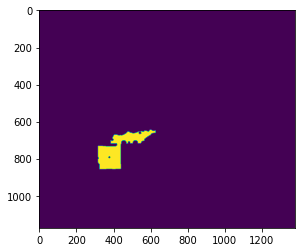

#goToPoint point: [494, 708], min_distance: 20, release_mouse_on_end:True, release_mouse_on_start:False
randomize_grid_pos_to_go: False, random_val: 1
custom_break_function:<bound method Simulacrum.scanForInterestingEntities of <__main__.Simulacrum object at 0x0000014332A57190>>, custom_continue_function:<bound method BarrierInvocationInfernalist.usualRoutine of <__main__.BarrierInvocationInfernalist object at 0x0000014331976250>>
heist_transition: False, step_size: 33possible_transition: False
end pos to go 494 708 
[Mover.goToPoint] len(path): 97
[Mover] distance_to_target: 67.60177512462229 at 1738024450.27434
[pather.cropPath] point [698 455] 47 is reachable in 97
[Mover] making step to (777, 241)
[Mover] making first step, placing a mouse on (777, 241) and going 
[Controller] debug sending action=mouseSetCursorPosSmooth&x=777&y=241&mtm=-1&msm=1&wtr=1& at 1738024450.2813373
[Controller] debug recieved response for action=mouseSetCursorPosSmooth&x=777&y=241&mtm=-1&msm=1&wtr=1& at 17

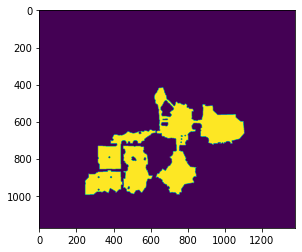

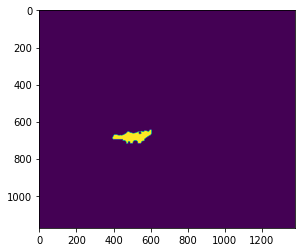

arena center [500, 680]
[570, 680] [570, 680]
[430, 680] [430, 680]
[500. 717.   0.]
[500, 750] [500, 716]
[500. 660.   0.]
[500, 610] [500, 661]


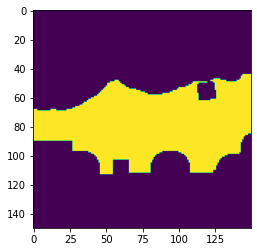

#goToPoint point: [570, 680], min_distance: 30, release_mouse_on_end:False, release_mouse_on_start:False
randomize_grid_pos_to_go: True, random_val: 1
custom_break_function:<function alwaysFalseFunction at 0x0000014330B32C10>, custom_continue_function:None
heist_transition: False, step_size: 30possible_transition: False
end pos to go 570 681 
[Mover.goToPoint] len(path): 100
[Mover] distance_to_target: 82.22530024268686 at 1738024456.057589
[pather.cropPath] point [685 538] 63 is reachable in 100
[Mover] making step to (882, 199)
[Mover] making first step, placing a mouse on (882, 199) and going 
[Controller] debug sending action=mouseSetCursorPosSmooth&x=882&y=199&mtm=-1&msm=1&wtr=1& at 1738024456.0595798
[Controller] debug recieved response for action=mouseSetCursorPosSmooth&x=882&y=199&mtm=-1&msm=1&wtr=1& at 1738024456.060597
[Mover.moveWASD] gonna move by angle 90
[Controller] debug sending action=keyboard_pressKey&button_code=DIK_D&wtr=1& at 1738024456.060597
[Controller] debug re

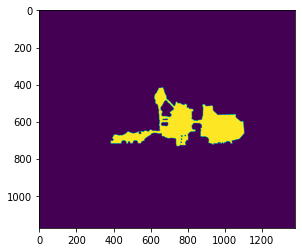

[poebot] #refreshAll call at 1738024490.3306944


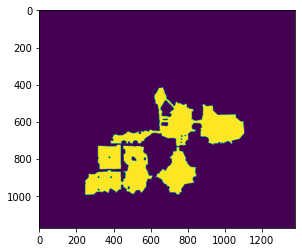

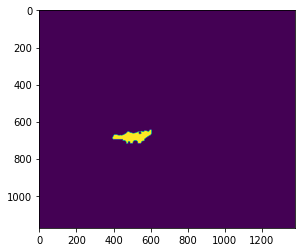

arena center [500, 680]
[570, 680] [570, 680]
[430, 680] [430, 680]
[500. 717.   0.]
[500, 750] [500, 716]
[500. 660.   0.]
[500, 610] [500, 661]


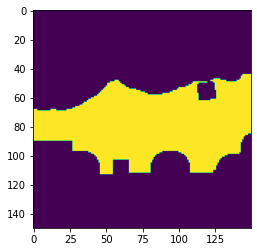

#goToPoint point: [570, 680], min_distance: 30, release_mouse_on_end:False, release_mouse_on_start:False
randomize_grid_pos_to_go: True, random_val: 1
custom_break_function:<function alwaysFalseFunction at 0x0000014330B32C10>, custom_continue_function:None
heist_transition: False, step_size: 30possible_transition: False
end pos to go 570 680 
useless call of gotopoint arrived = True
[Mover.goToPoint] len(path): 10
wave running status True
#goToPoint point: [430, 680], min_distance: 30, release_mouse_on_end:False, release_mouse_on_start:False
randomize_grid_pos_to_go: True, random_val: 1
custom_break_function:<function alwaysFalseFunction at 0x0000014330B32C10>, custom_continue_function:None
heist_transition: False, step_size: 30possible_transition: False
end pos to go 431 680 
[Mover.goToPoint] len(path): 149
[Mover] distance_to_target: 144.05554484295286 at 1738024491.5193012
[pather.cropPath] point [678 525] 52 is reachable in 149
[Mover] making step to (417, 658)
[Mover] making firs

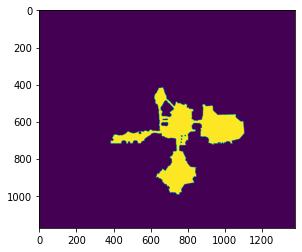

#goToPoint point: [812, 649], min_distance: 20, release_mouse_on_end:True, release_mouse_on_start:False
randomize_grid_pos_to_go: False, random_val: 1
custom_break_function:<bound method Simulacrum.scanForInterestingEntities of <__main__.Simulacrum object at 0x0000014332A57190>>, custom_continue_function:<bound method BarrierInvocationInfernalist.usualRoutine of <__main__.BarrierInvocationInfernalist object at 0x0000014331976250>>
heist_transition: False, step_size: 33possible_transition: False
end pos to go 812 649 
[Mover.goToPoint] len(path): 386
[Mover] distance_to_target: 372.9785516621566 at 1738024494.3090105
[pather.cropPath] point [671 495] 46 is reachable in 386
[Mover] making step to (968, 200)
[Mover] making first step, placing a mouse on (968, 200) and going 
[Controller] debug sending action=mouseSetCursorPosSmooth&x=968&y=200&mtm=-1&msm=1&wtr=1& at 1738024494.3130095
[Controller] debug recieved response for action=mouseSetCursorPosSmooth&x=968&y=200&mtm=-1&msm=1&wtr=1& a

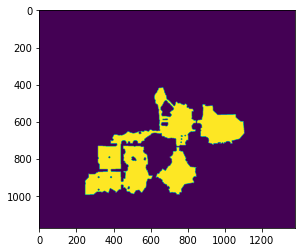

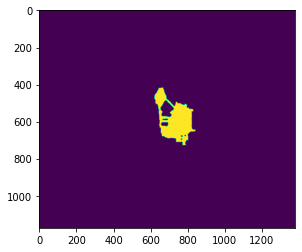

arena center [732, 571]
[802, 571] [802, 571]
[709. 571.   0.]
[662, 571] [710, 571]
[732, 641] [732, 641]
[732. 515.   0.]
[732, 501] [732, 516]


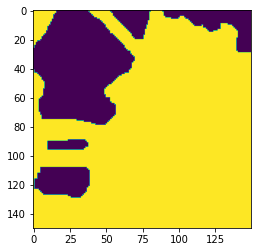

#goToPoint point: [802, 571], min_distance: 30, release_mouse_on_end:False, release_mouse_on_start:False
randomize_grid_pos_to_go: True, random_val: 1
custom_break_function:<function alwaysFalseFunction at 0x0000014330B32C10>, custom_continue_function:None
heist_transition: False, step_size: 30possible_transition: False
end pos to go 802 572 
[Mover.goToPoint] len(path): 84
[Mover] distance_to_target: 79.10120100226038 at 1738024502.7852187
[pather.cropPath] point [601 804] 52 is reachable in 84
[Mover] making step to (467, 242)
[Mover] making first step, placing a mouse on (467, 242) and going 
[Controller] debug sending action=mouseSetCursorPosSmooth&x=467&y=242&mtm=-1&msm=1&wtr=1& at 1738024502.7932215
[Controller] debug recieved response for action=mouseSetCursorPosSmooth&x=467&y=242&mtm=-1&msm=1&wtr=1& at 1738024502.7962203
[Mover.moveWASD] gonna move by angle 0
[Controller] debug sending action=keyboard_pressKey&button_code=DIK_W&wtr=1& at 1738024502.7972188
[Controller] debug re

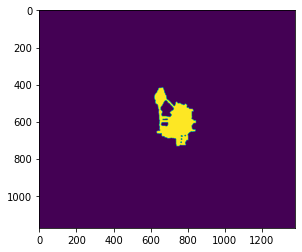

[poebot] #refreshAll call at 1738024544.0257604


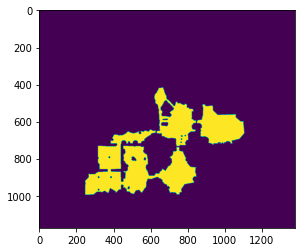

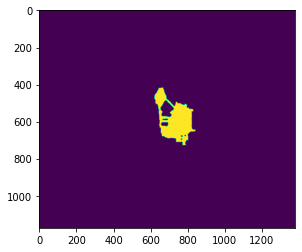

arena center [732, 571]
[802, 571] [802, 571]
[709. 571.   0.]
[662, 571] [710, 571]
[732, 641] [732, 641]
[732. 515.   0.]
[732, 501] [732, 516]


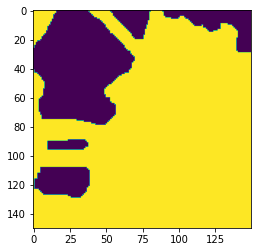

#goToPoint point: [802, 571], min_distance: 30, release_mouse_on_end:False, release_mouse_on_start:False
randomize_grid_pos_to_go: True, random_val: 1
custom_break_function:<function alwaysFalseFunction at 0x0000014330B32C10>, custom_continue_function:None
heist_transition: False, step_size: 30possible_transition: False
end pos to go 803 572 
[Mover.goToPoint] len(path): 90
[Mover] distance_to_target: 63.411355449950754 at 1738024545.1583517
[pather.cropPath] point [574 780] 64 is reachable in 90
[Mover] making step to (580, 196)
[Mover] making first step, placing a mouse on (580, 196) and going 
[Controller] debug sending action=mouseSetCursorPosSmooth&x=580&y=196&mtm=-1&msm=1&wtr=1& at 1738024545.1603496
[Controller] debug recieved response for action=mouseSetCursorPosSmooth&x=580&y=196&mtm=-1&msm=1&wtr=1& at 1738024545.161351
[Mover.moveWASD] gonna move by angle 0
[Controller] debug sending action=keyboard_pressKey&button_code=DIK_W&wtr=1& at 1738024545.1623516
[Controller] debug re

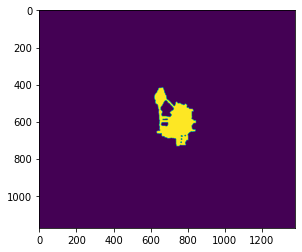

#goToPoint point: [812, 649], min_distance: 20, release_mouse_on_end:True, release_mouse_on_start:False
randomize_grid_pos_to_go: False, random_val: 1
custom_break_function:<bound method Simulacrum.scanForInterestingEntities of <__main__.Simulacrum object at 0x0000014332A57190>>, custom_continue_function:<bound method BarrierInvocationInfernalist.usualRoutine of <__main__.BarrierInvocationInfernalist object at 0x0000014331976250>>
heist_transition: False, step_size: 33possible_transition: False
end pos to go 812 649 
[Mover.goToPoint] len(path): 119
[Mover] distance_to_target: 86.34813257969161 at 1738024547.0895395
[pather.cropPath] point [620 789] 66 is reachable in 119
[Mover] making step to (947, 674)
[Mover] making first step, placing a mouse on (947, 674) and going 
[Controller] debug sending action=mouseSetCursorPosSmooth&x=947&y=674&mtm=-1&msm=1&wtr=1& at 1738024547.0945404
[Controller] debug recieved response for action=mouseSetCursorPosSmooth&x=947&y=674&mtm=-1&msm=1&wtr=1& a

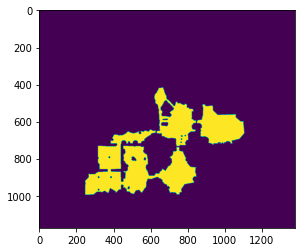

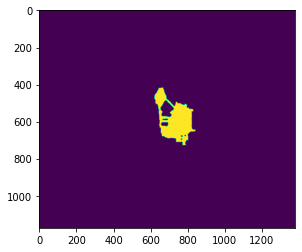

arena center [732, 571]
[802, 571] [802, 571]
[709. 571.   0.]
[662, 571] [710, 571]
[732, 641] [732, 641]
[732. 515.   0.]
[732, 501] [732, 516]


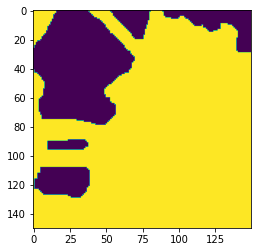

#goToPoint point: [802, 571], min_distance: 30, release_mouse_on_end:False, release_mouse_on_start:False
randomize_grid_pos_to_go: True, random_val: 1
custom_break_function:<function alwaysFalseFunction at 0x0000014330B32C10>, custom_continue_function:None
heist_transition: False, step_size: 30possible_transition: False
end pos to go 801 570 
[Mover.goToPoint] len(path): 76
[Mover] distance_to_target: 68.35934464285042 at 1738024550.0906832
[pather.cropPath] point [588 803] 55 is reachable in 76
[Mover] making step to (450, 258)
[Mover] making first step, placing a mouse on (450, 258) and going 
[Controller] debug sending action=mouseSetCursorPosSmooth&x=450&y=258&mtm=-1&msm=1&wtr=1& at 1738024550.0946836
[Controller] debug recieved response for action=mouseSetCursorPosSmooth&x=450&y=258&mtm=-1&msm=1&wtr=1& at 1738024550.0946836
[Mover.moveWASD] gonna move by angle 0
[Controller] debug sending action=keyboard_pressKey&button_code=DIK_A&wtr=1& at 1738024550.0956836
[Controller] debug re

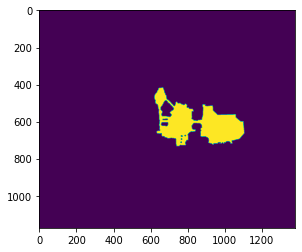

#goToPoint point: [935, 702], min_distance: 20, release_mouse_on_end:True, release_mouse_on_start:False
randomize_grid_pos_to_go: False, random_val: 1
custom_break_function:<bound method Simulacrum.scanForInterestingEntities of <__main__.Simulacrum object at 0x0000014332A57190>>, custom_continue_function:<bound method BarrierInvocationInfernalist.usualRoutine of <__main__.BarrierInvocationInfernalist object at 0x0000014331976250>>
heist_transition: False, step_size: 33possible_transition: False
end pos to go 935 702 
[Mover.goToPoint] len(path): 301
[Mover] distance_to_target: 220.51303816327962 at 1738024588.9542966
[pather.cropPath] point [607 791] 55 is reachable in 301
[Mover] making step to (982, 216)
[Mover] making first step, placing a mouse on (982, 216) and going 
[Controller] debug sending action=mouseSetCursorPosSmooth&x=982&y=216&mtm=-1&msm=1&wtr=1& at 1738024588.964301
[Controller] debug recieved response for action=mouseSetCursorPosSmooth&x=982&y=216&mtm=-1&msm=1&wtr=1& a

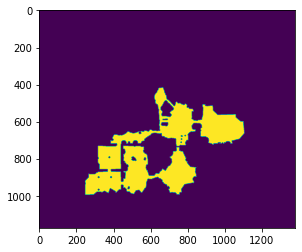

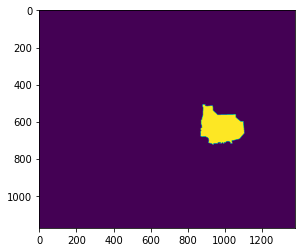

arena center [988, 615]
[1058, 615] [1058, 615]
[918, 615] [918, 615]
[988, 685] [988, 685]
[988. 562.   0.]
[988, 545] [988, 563]


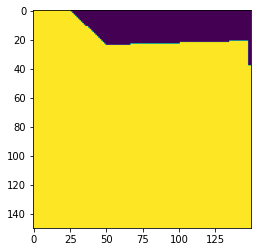

#goToPoint point: [1058, 615], min_distance: 30, release_mouse_on_end:False, release_mouse_on_start:False
randomize_grid_pos_to_go: True, random_val: 1
custom_break_function:<function alwaysFalseFunction at 0x0000014330B32C10>, custom_continue_function:None
heist_transition: False, step_size: 30possible_transition: False
end pos to go 1059 616 
[Mover.goToPoint] len(path): 203
[Mover] distance_to_target: 147.14618581533128 at 1738024595.4500167
[pather.cropPath] point [670 979] 68 is reachable in 203
[Mover] making step to (822, 184)
[Mover] making first step, placing a mouse on (822, 184) and going 
[Controller] debug sending action=mouseSetCursorPosSmooth&x=822&y=184&mtm=-1&msm=1&wtr=1& at 1738024595.4530187
[Controller] debug recieved response for action=mouseSetCursorPosSmooth&x=822&y=184&mtm=-1&msm=1&wtr=1& at 1738024595.4540184
[Mover.moveWASD] gonna move by angle 45
[Controller] debug sending action=keyboard_pressKey&button_code=DIK_W&wtr=1& at 1738024595.4540184
[Controller] de

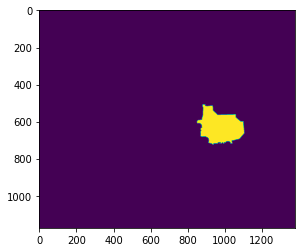

#goToPoint point: [935, 702], min_distance: 20, release_mouse_on_end:True, release_mouse_on_start:False
randomize_grid_pos_to_go: False, random_val: 1
custom_break_function:<bound method Simulacrum.scanForInterestingEntities of <__main__.Simulacrum object at 0x0000014332A57190>>, custom_continue_function:<bound method BarrierInvocationInfernalist.usualRoutine of <__main__.BarrierInvocationInfernalist object at 0x0000014331976250>>
heist_transition: False, step_size: 33possible_transition: False
end pos to go 935 702 
[Mover.goToPoint] len(path): 158
[Mover] distance_to_target: 128.3160161476345 at 1738024638.501068
[pather.cropPath] point [ 690 1008] 72 is reachable in 158
[Mover] making step to (578, 674)
[Mover] making first step, placing a mouse on (578, 674) and going 
[Controller] debug sending action=mouseSetCursorPosSmooth&x=578&y=674&mtm=-1&msm=1&wtr=1& at 1738024638.5060697
[Controller] debug recieved response for action=mouseSetCursorPosSmooth&x=578&y=674&mtm=-1&msm=1&wtr=1& 

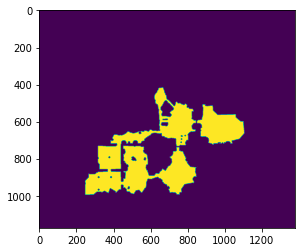

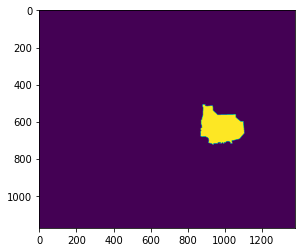

arena center [988, 615]
[1058, 615] [1058, 615]
[918, 615] [918, 615]
[988, 685] [988, 685]
[988. 562.   0.]
[988, 545] [988, 563]
terminating thread due to inactivity
[ButtonHolder.start] finished at 1738024642.5103443


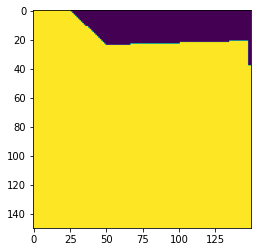

#goToPoint point: [1058, 615], min_distance: 30, release_mouse_on_end:False, release_mouse_on_start:False
randomize_grid_pos_to_go: True, random_val: 1
custom_break_function:<function alwaysFalseFunction at 0x0000014330B32C10>, custom_continue_function:None
heist_transition: False, step_size: 30possible_transition: False
end pos to go 1058 615 
[Mover.goToPoint] len(path): 200
[Mover] distance_to_target: 143.96180048887967 at 1738024642.6448815
[pather.cropPath] point [673 983] 66 is reachable in 200
[Mover] making step to (833, 191)
[Mover] making first step, placing a mouse on (833, 191) and going 
[Controller] debug sending action=mouseSetCursorPosSmooth&x=833&y=191&mtm=-1&msm=1&wtr=1& at 1738024642.648882
[Controller] debug recieved response for action=mouseSetCursorPosSmooth&x=833&y=191&mtm=-1&msm=1&wtr=1& at 1738024642.648882
[Mover.moveWASD] gonna move by angle 45
[Controller] debug sending action=keyboard_pressKey&button_code=DIK_W&wtr=1& at 1738024642.6498816
[Controller] debu

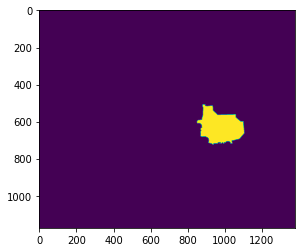

#goToPoint point: [935, 702], min_distance: 20, release_mouse_on_end:True, release_mouse_on_start:False
randomize_grid_pos_to_go: False, random_val: 1
custom_break_function:<bound method Simulacrum.scanForInterestingEntities of <__main__.Simulacrum object at 0x0000014332A57190>>, custom_continue_function:<bound method BarrierInvocationInfernalist.usualRoutine of <__main__.BarrierInvocationInfernalist object at 0x0000014331976250>>
heist_transition: False, step_size: 33possible_transition: False
end pos to go 935 702 
[Mover.goToPoint] len(path): 143
[Mover] distance_to_target: 111.32834320154055 at 1738024682.5351174
[pather.cropPath] point [675 985] 65 is reachable in 143
[Mover] making step to (486, 674)
[Mover] making first step, placing a mouse on (486, 674) and going 
[Controller] debug sending action=mouseSetCursorPosSmooth&x=486&y=674&mtm=-1&msm=1&wtr=1& at 1738024682.544117
[Controller] debug recieved response for action=mouseSetCursorPosSmooth&x=486&y=674&mtm=-1&msm=1&wtr=1& a

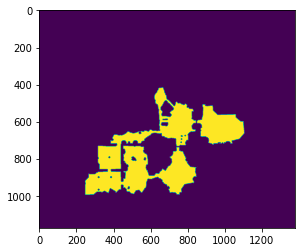

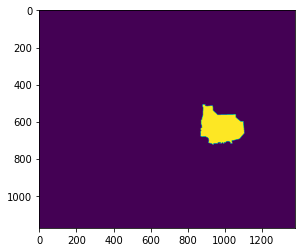

arena center [988, 615]
[1058, 615] [1058, 615]
[918, 615] [918, 615]
[988, 685] [988, 685]
[988. 562.   0.]
[988, 545] [988, 563]
terminating thread due to inactivity
[ButtonHolder.start] finished at 1738024686.3787787


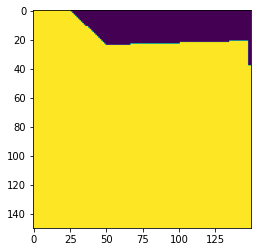

#goToPoint point: [1058, 615], min_distance: 30, release_mouse_on_end:False, release_mouse_on_start:False
randomize_grid_pos_to_go: True, random_val: 1
custom_break_function:<function alwaysFalseFunction at 0x0000014330B32C10>, custom_continue_function:None
heist_transition: False, step_size: 30possible_transition: False
end pos to go 1057 614 
[Mover.goToPoint] len(path): 220
[Mover] distance_to_target: 156.82155464093574 at 1738024686.44776
[pather.cropPath] point [679 973] 70 is reachable in 220
[Mover] making step to (780, 180)
[Mover] making first step, placing a mouse on (780, 180) and going 
[Controller] debug sending action=mouseSetCursorPosSmooth&x=780&y=180&mtm=-1&msm=1&wtr=1& at 1738024686.45276
[Controller] debug recieved response for action=mouseSetCursorPosSmooth&x=780&y=180&mtm=-1&msm=1&wtr=1& at 1738024686.45276
[Mover.moveWASD] gonna move by angle 45
[Controller] debug sending action=keyboard_pressKey&button_code=DIK_W&wtr=1& at 1738024686.4537692
[Controller] debug re

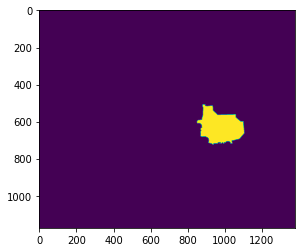

[poebot] #refreshAll call at 1738024728.9211636


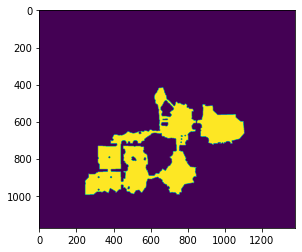

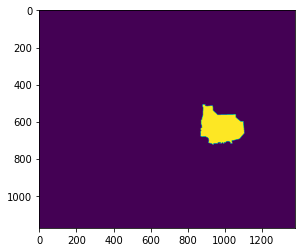

arena center [988, 615]
[1058, 615] [1058, 615]
[918, 615] [918, 615]
[988, 685] [988, 685]
[988. 562.   0.]
[988, 545] [988, 563]


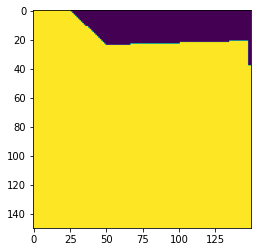

#goToPoint point: [1058, 615], min_distance: 30, release_mouse_on_end:False, release_mouse_on_start:False
randomize_grid_pos_to_go: True, random_val: 1
custom_break_function:<function alwaysFalseFunction at 0x0000014330B32C10>, custom_continue_function:None
heist_transition: False, step_size: 30possible_transition: False
end pos to go 1058 615 
[Mover.goToPoint] len(path): 72
terminating thread due to inactivity[Mover] distance_to_target: 54.230987451824994 at 1738024730.4657605

[ButtonHolder.start] finished at 1738024730.466761
[pather.cropPath] point [ 615 1047] 60 is reachable in 72
[Mover] making step to (561, 208)
[Mover] making first step, placing a mouse on (561, 208) and going 
[Controller] debug sending action=mouseSetCursorPosSmooth&x=561&y=208&mtm=-1&msm=1&wtr=1& at 1738024730.4707608
[Controller] debug recieved response for action=mouseSetCursorPosSmooth&x=561&y=208&mtm=-1&msm=1&wtr=1& at 1738024730.4717636
[Mover.moveWASD] gonna move by angle 0
[Controller] debug sending 

KeyboardInterrupt: 

terminating thread due to inactivity
[ButtonHolder.start] finished at 1738024741.0093307


In [23]:
while True:
  poe_bot.refreshAll()
  # plt.imshow(poe_bot.pather.terrain_for_a_star);plt.show()

  poe_bot.game_data.terrain.getCurrentlyPassableArea(dilate_kernel_size=0)
  plt.imshow(poe_bot.game_data.terrain.currently_passable_area);plt.show()

  poe_bot.pather.terrain_for_a_star[poe_bot.game_data.terrain.currently_passable_area != 1] = 65534

  simulacrum.activateWave()
  # plt.imshow(poe_bot.pather.terrain_for_a_star);plt.show()
  poe_bot.refreshAll()
  # plt.imshow(poe_bot.game_data.terrain.terrain_image);plt.show()
  plt.imshow(poe_bot.game_data.terrain.passable);plt.show()
  # shut the doors
  for interesting_entitiy in interesting_entities:
    poe_bot.game_data.terrain.passable[interesting_entitiy.grid_position.y-25:interesting_entitiy.grid_position.y+25, interesting_entitiy.grid_position.x-25:interesting_entitiy.grid_position.x+25] = 0

  poe_bot.game_data.terrain.getCurrentlyPassableArea(dilate_kernel_size=0)
  plt.imshow(poe_bot.game_data.terrain.currently_passable_area);plt.show()

  arena_center = poe_bot.pather.utils.getCenterOf(poe_bot.game_data.terrain.currently_passable_area)
  print(f'arena center {arena_center}')

  points = getFourPoints(*arena_center, 70)


  run_points = []

  for point in points[1:]:
    line_vals = createLineIteratorWithValues(arena_center, point, poe_bot.game_data.terrain.currently_passable_area)
    last_point = arena_center
    # print(line_vals)
    for line_point in line_vals[10:]:
      if line_point[-1] != 1.:
        print(line_point)
        break
      last_point = line_point
    run_points.append([int(last_point[0]), int(last_point[1])])
    # passable_point = poe_bot.game_data.terrain.checkIfPointPassable(*point)

    print(f'{point} {run_points[-1]}')

  plt.imshow(poe_bot.game_data.terrain.currently_passable_area[arena_center[1]-75:arena_center[1]+75, arena_center[0]-75:arena_center[0]+75]);plt.show()


  wave_started_at = time.time()
  is_wave_running = True
  while is_wave_running:
    for point in run_points:
      poe_bot.mover.goToPoint(point,release_mouse_on_end=False)
      if time.time() + 10 > wave_started_at:
        is_wave_running = simulacrum.isWaveRunning()
      if is_wave_running == False:
        break
      print(f'wave running status {is_wave_running}')

  poe_bot.refreshInstanceData()
  poe_bot.loot_picker.collectLootWhilePresented()

  print(f'wave completed')




In [ ]:
plt.imshow(poe_bot.game_data.terrain.currently_passable_area);plt.show()
plt.imshow(poe_bot.game_data.terrain.currently_passable_area[1034-50:1034+50,311-50:311+50 ]);plt.show()

In [ ]:
plt.imshow(poe_bot.game_data.terrain.currently_passable_area);plt.show()


In [ ]:
print(arena_center)


points = getFourPoints(*arena_center, 70)

run_points = []

for point in points[1:]:
  line_vals = createLineIteratorWithValues(arena_center, point, poe_bot.game_data.terrain.currently_passable_area)
  last_point = arena_center
  # print(line_vals)
  for line_point in line_vals[10:]:
    if line_point[-1] != 1.:
      print(line_point)
      break
    last_point = line_point
  run_points.append([int(last_point[0]), int(last_point[1])])
  # passable_point = poe_bot.game_data.terrain.checkIfPointPassable(*point)

  print(f'{point} {run_points[-1]}')
  # if passable_point:
  #   run_points.append(point)


In [ ]:
for point in run_points:
  poe_bot.mover.goToPoint(point,release_mouse_on_end=False, custom_continue_function=lambda *args, **kwargs: False)

In [ ]:
press_func = poe_bot.bot_controls.keyboard_pressKey
release_func = poe_bot.bot_controls.keyboacrd_releaseKey

In [ ]:
poe_bot.refreshAll()

In [ ]:
plt.imshow(poe_bot.game_data.terrain.terrain_image)

In [ ]:
poe_bot.refreshAll()
plt.imshow(poe_bot.game_data.terrain.terrain_image)


In [ ]:
# activate wave


In [ ]:
poe_bot.refreshAll()
poe_bot.game_data.terrain.getCurrentlyPassableArea(dilate_kernel_size=0)
plt.imshow(poe_bot.game_data.terrain.currently_passable_area);plt.show()
points = poe_bot.pather.tsp.generatePointsForDiscovery()
print(points)


In [ ]:



bh = ButtonHolder("DIK_E")
bh.holdFor(12.0)


In [ ]:
bh.forceStopPress()

In [ ]:
bh.holdFor(10.0)

In [ ]:
bh.thread_finished[0] = True

In [ ]:
poe_bot.bot_controls.keyboard.pressed

In [ ]:
poe_bot.bot_controls.keyboard_pressKey('DIK_F')

In [ ]:
poe_bot.bot_controls.keyboard_releaseKey('DIK_F')

In [ ]:
"DIK_F" in poe_bot.bot_controls.keyboard.pressed